In [3]:
# conda base

# Data manipulation 
import pandas as pd 
import numpy as np
import os

# smiles manipulation
from rdkit.DataStructs.cDataStructs import TanimotoSimilarity
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit import Chem
import itertools
import scipy.cluster.hierarchy as shc

# Data viz
import matplotlib.pyplot as plt 
from matplotlib.patches import Patch
import seaborn as sns

This notebook shows how to merge the data of sequences retrived from [BLDB](http://bldb.eu/) and MICs from [BLDB2](https://ifr48.timone.univ-mrs.fr/beta-lactamase/public/) to create the main dataset. It also includes the procedure to create a second dataset of enzyme kinetics not analyzed in this master thesis. Finally shows how to compute the tanimoto similarity between 50 betalactam antibiotics.


# mics

## data source 

We have 42 dsets with mics. Each one is manually named by superfam and class of bla. We want to merge all in one per class: metalo_B, serin_A, serin_C, serin_D

In [1]:
! ls ../data/bldb2/mics 

metalo_B_AIM.csv   metalo_B_VIM.csv   serin_A_OXY.csv	serin_C_ACT.csv
metalo_B_BlaB.csv  serin_A_AST.csv    serin_A_PER.csv	serin_C_CFE.csv
metalo_B_DIM.csv   serin_A_BEL.csv    serin_A_PME.csv	serin_C_CMY.csv
metalo_B_EBR.csv   serin_A_BES.csv    serin_A_RAHN.csv	serin_C_DHA.csv
metalo_B_GOB.csv   serin_A_BIC.csv    serin_A_SED.csv	serin_C_FOX.csv
metalo_B_IMIH.csv  serin_A_CARB.csv   serin_A_SFO.csv	serin_C_MIR.csv
metalo_B_IMP.csv   serin_A_CTX_M.csv  serin_A_SHV.csv	serin_C_MOR.csv
metalo_B_IND.csv   serin_A_ERP.csv    serin_A_SME.csv	serin_C_TRU.csv
metalo_B_MUS.csv   serin_A_GES.csv    serin_A_TEM.csv	serin_D_OXA.csv
metalo_B_NDM.csv   serin_A_KPC.csv    serin_A_VEB.csv
metalo_B_TUS.csv   serin_A_LUT.csv    serin_C_ACC.csv


For each class, read all csvs that correspond to the class and add the respective label

In [4]:
path = "../data/bldb2/mics/" 

# dset class a
csv_a = [] 

# load csvs per each class 
for file in os.listdir(path):
    if file.startswith("serin_A"): 
        csv_a.append(file)

# append dsets to a list
li = []
for dset in csv_a:
    path2 = path + dset
    df = pd.read_csv(path2, index_col=None, header=0)
    li.append(df)

# concatenate and add new cols
class_a = pd.concat(li, axis=0, ignore_index=True)
class_a["family"]    = class_a["Protein Name"].str.replace('-\d*$', '')
class_a["bla_class"] = "Class A"
class_a

/tmp/ipykernel_2217/1941560600.py:20: FutureWarning: The default value of regex will change from True to False in a future version.
  class_a["family"] = class_a["Protein Name"].str.replace('-\d*$', '')


,Protein Name,Antibiotics,Without Bla MIC (µg/ml),With Bla MIC (µg/ml),Fold,family,bla_class
0,SFO-1,Amoxicillin,1.000,256.00,256.0000,SFO,Class A
1,SFO-1,Amoxicillin-CLA,2.000,256.00,128.0000,SFO,Class A
2,SFO-1,Ceftazidime,0.125,16.00,128.0000,SFO,Class A
3,SFO-1,Piperacillin,0.500,256.00,512.0000,SFO,Class A
4,SFO-1,Imipenem,0.250,0.50,2.0000,SFO,Class A
...,...,...,...,...,...,...,...
1152,BIC-1,Ticarcillin,4.000,256.00,64.0000,BIC,Class A
1153,BIC-1,Amoxicillin-CLA,4.000,16.00,4.0000,BIC,Class A
1154,BIC-1,Imipenem,0.120,2.00,16.6667,BIC,Class A
1155,BIC-1,Ceftazidime,0.500,0.50,1.0000,BIC,Class A


In [5]:
# dset class b
csv_b = [] 

# load csvs per each class 
for file in os.listdir(path):
    if file.startswith("metalo_B"): 
        csv_b.append(file)

# append dsets to a list
li = []
for dset in csv_b:
    path2 = path + dset
    df = pd.read_csv(path2, index_col=None, header=0)
    li.append(df)

# concatenate and add new cols
class_b = pd.concat(li, axis=0, ignore_index=True)
class_b["family"]    = class_b["Protein Name"].str.replace('-\d*$', '')
class_b["bla_class"] = "Class B"
class_b

/tmp/ipykernel_2217/348338712.py:18: FutureWarning: The default value of regex will change from True to False in a future version.
  class_b["family"] = class_b["Protein Name"].str.replace('-\d*$', '')


,Protein Name,Antibiotics,Without Bla MIC (µg/ml),With Bla MIC (µg/ml),Fold,family,bla_class
0,IMIH,Ampicillin,0.01,3.00,300.000000,IMIH,Class B
1,IMIH,Cephalothin,9.00,4.00,0.444444,IMIH,Class B
2,IMIH,Imipenem,0.01,19.00,1900.000000,IMIH,Class B
3,IMIH,Meropenem,0.01,57.00,5700.000000,IMIH,Class B
4,EBR-1,Amoxicillin,2.00,512.00,256.000000,EBR,Class B
...,...,...,...,...,...,...,...
525,NDM-8,Moxalactam,0.25,16.00,64.000000,NDM,Class B
526,NDM-8,Aztreonam,0.03,0.03,1.000000,NDM,Class B
527,NDM-8,Cefuroxime,4.00,512.00,128.000000,NDM,Class B
528,NDM-8,Cefpirome,0.25,2.00,8.000000,NDM,Class B


In [6]:
# dset class b
csv_c = [] 

# load csvs per each class 
for file in os.listdir(path):
    if file.startswith("serin_C"): 
        csv_c.append(file)

# append dsets to a list
li = []
for dset in csv_c:
    path2 = path + dset
    df = pd.read_csv(path2, index_col=None, header=0)
    li.append(df)

# concatenate and add new cols
class_c = pd.concat(li, axis=0, ignore_index=True)
class_c["family"]    = class_c["Protein Name"].str.replace('-\d*$', '')
class_c["bla_class"] = "Class C"
class_c

/tmp/ipykernel_2217/1680572238.py:18: FutureWarning: The default value of regex will change from True to False in a future version.
  class_c["family"]    = class_c["Protein Name"].str.replace('-\d*$', '')


,Protein Name,Antibiotics,Without Bla MIC (µg/ml),With Bla MIC (µg/ml),Fold,family,bla_class
0,MOR,Amoxicillin,8.000,256.00,32.000,MOR,Class C
1,MOR,Imipenem,0.250,0.25,1.000,MOR,Class C
2,MOR,Cefoxitin,4.000,8.00,2.000,MOR,Class C
3,MOR,Ticarcillin,4.000,16.00,4.000,MOR,Class C
4,MOR,Amoxicillin-CLA,4.000,256.00,64.000,MOR,Class C
...,...,...,...,...,...,...,...
287,FOX-8,Piperacillin-TZB,1.000,4.00,4.000,FOX,Class C
288,FOX-8,Cephalothin,2.000,512.00,256.000,FOX,Class C
289,FOX-8,Cefotaxime,0.047,8.00,170.213,FOX,Class C
290,FOX-8,Ampicillin,2.000,64.00,32.000,FOX,Class C


In [7]:
# dset class b
csv_d = [] 

# load csvs per each class 
for file in os.listdir(path):
    if file.startswith("serin_D"): 
        csv_d.append(file)

# append dsets to a list
li = []
for dset in csv_d:
    path2 = path + dset
    df = pd.read_csv(path2, index_col=None, header=0)
    li.append(df)

# concatenate and add new cols
class_d = pd.concat(li, axis=0, ignore_index=True)
class_d["family"]    = class_d["Protein Name"].str.replace('-\d*$', '')
class_d["bla_class"] = "Class D"
class_d

/tmp/ipykernel_2217/1873870546.py:18: FutureWarning: The default value of regex will change from True to False in a future version.
  class_d["family"]    = class_d["Protein Name"].str.replace('-\d*$', '')


,Protein Name,Antibiotics,Without Bla MIC (µg/ml),With Bla MIC (µg/ml),Fold,family,bla_class
0,OXA-114,Cefoxitin,4.00,4.00,1.00000,OXA,Class D
1,OXA-114,Ticarcillin,2.00,4.00,2.00000,OXA,Class D
2,OXA-114,Piperacillin-TZB,1.00,4.00,4.00000,OXA,Class D
3,OXA-114,Imipenem,0.06,0.06,1.00000,OXA,Class D
4,OXA-114,Ceftazidime,0.06,0.06,1.00000,OXA,Class D
...,...,...,...,...,...,...,...
399,OXA-97,Ampicillin,4.00,512.00,128.00000,OXA,Class D
400,OXA-97,Imipenem,0.06,1.00,16.66670,OXA,Class D
401,OXA-97,Ticarcillin,4.00,512.00,128.00000,OXA,Class D
402,OXA-97,Meropenem,0.06,0.50,8.33333,OXA,Class D


In [8]:
# merge all classes in one dset 
df_mics = pd.concat([class_a, class_b, class_c, class_d], axis=0, ignore_index=True)
print(f"All dsets contain {len(df_mics)} mic values")
df_mics

All dsets contain 2383 mic values


,Protein Name,Antibiotics,Without Bla MIC (µg/ml),With Bla MIC (µg/ml),Fold,family,bla_class
0,SFO-1,Amoxicillin,1.000,256.00,256.00000,SFO,Class A
1,SFO-1,Amoxicillin-CLA,2.000,256.00,128.00000,SFO,Class A
2,SFO-1,Ceftazidime,0.125,16.00,128.00000,SFO,Class A
3,SFO-1,Piperacillin,0.500,256.00,512.00000,SFO,Class A
4,SFO-1,Imipenem,0.250,0.50,2.00000,SFO,Class A
...,...,...,...,...,...,...,...
2378,OXA-97,Ampicillin,4.000,512.00,128.00000,OXA,Class D
2379,OXA-97,Imipenem,0.060,1.00,16.66670,OXA,Class D
2380,OXA-97,Ticarcillin,4.000,512.00,128.00000,OXA,Class D
2381,OXA-97,Meropenem,0.060,0.50,8.33333,OXA,Class D


Group all antibiotics into 4 main classes according to:
- http://proteininformatics.org/mkumar/lactamasedb/lactamase.html
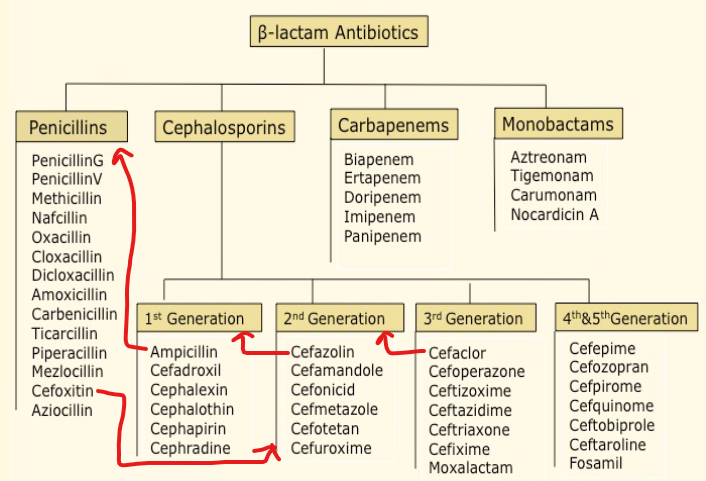

The above figure shows a map of betalactam antibiotics, but the red arrows indicate errors that i found in this classification "manually curated".

The final version, considering the errors and adding the sets with inhibitors is the following:
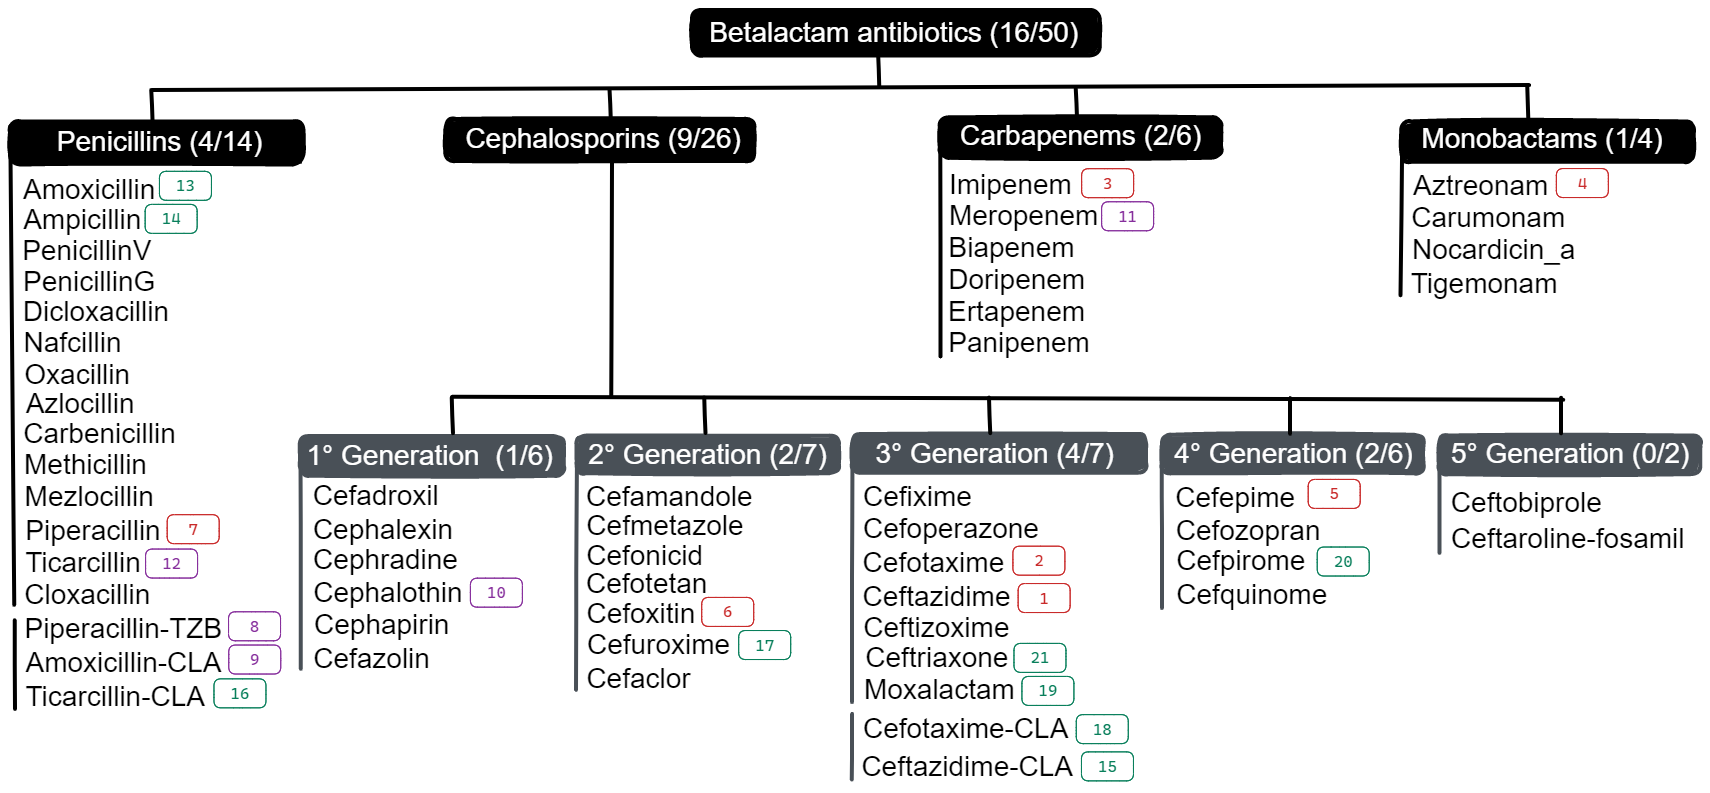


In [9]:
# rename cols
df_mics.rename(columns={ 
    "Protein Name": "protein_name", 
    "Antibiotics":"antibiotic", 
    "Without Bla MIC (µg/ml)":"mic_without_bla",
    "With Bla MIC (µg/ml)":"mic_with_bla", 
    "Fold":"fold"}, 
    inplace=True)

In [10]:
# add antibiotic class
penicillins = ["Amoxicillin", "Ampicillin", "PenicillinV", "PenicillinG","Dicloxacillin", "Nafcillin", "Oxacillin", 
               "Azlocillin", "Carbenicillin", "Methicillin", "Mezlocillin", "Piperacillin", "Ticarcillin", "Cloxacillin"]

cephalosporins_1 = ["Cefadroxil", "Cephalexin","Cephradine","Cephalothin","Cephapirin","Cefazolin"]

cephalosporins_2 = ["Cefamandole","Cefmetazole","Cefonicid","Cefotetan","Cefoxitin","Cefuroxime","Cefaclor"]

cephalosporins_3 = ["Cefixime","Cefoperazone","Cefotaxime","Ceftazidime","Ceftizoxime","Ceftriaxone","Moxalactam"]

cephalosporins_4 = ["Cefepime","Cefozopran","Cefpirome","Cefquinome"]

cephalosporins_5 = ["Ceftaroline_fosamil","Ceftobiprole"]

cephalosporins = cephalosporins_1 + cephalosporins_2 + cephalosporins_3 + cephalosporins_4 + cephalosporins_5

carbapenems = ["Imipenem","Meropenem","Biapenem","Doripenem","Ertapenem","Panipenem"]

monobactams = ["Aztreonam","Carumonam","Nocardicin_a","Tigemonam"]

filters = [df_mics.antibiotic.str.contains('|'.join(penicillins)), 
           df_mics.antibiotic.str.contains('|'.join(cephalosporins)),
           df_mics.antibiotic.str.contains('|'.join(carbapenems)),
           df_mics.antibiotic.str.contains('|'.join(monobactams))]

values = ["Penicillins", "Cephalosporins", "Carbapenems", "Monobactams"]

df_mics["antibiotic_class"] = np.select(filters, values)

# show an example
df_mics[df_mics.protein_name.str.contains("CTX-M-32") & df_mics.antibiotic.str.contains("Cefotaxime")]

,protein_name,antibiotic,mic_without_bla,mic_with_bla,fold,family,bla_class,antibiotic_class
189,CTX-M-32,Cefotaxime-CLA,0.02,0.03,1.5,CTX-M,Class A,Cephalosporins
192,CTX-M-32,Cefotaxime,0.02,256.00,12800.0,CTX-M,Class A,Cephalosporins


The fold column was calculated by [Keshri et al](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6496087/) through a rate, taking into account the minimum inhibitory concentration (MIC; in µg/ml) with and without the enzyme. 

As an example for CTX-M-32 and Cefotaxime:

$$ MIC_{without} =	0.02 $$

$$ MIC_{with} =	256 $$

$$ Fold = \dfrac{256}{0.02} = 12800 $$

Meaning of fold values in the resistance:
- 1: there is not change with or without the enzyme

- \>1: the enzyme confer resistance

- <1: there is no biological sense, since the addition of the enzyme reduce the resistance, maybe, due to errors during measurement assays or genetic charge to maintain the enzyme.

In [11]:
print(f" In total, there are {np.sum(df_mics.fold < 1)} cases for which fold values have <1 \n")
print(f"Enzymes: {df_mics[df_mics.fold < 1].iloc[:,0].unique()}")

 In total, there are 54 cases for which fold values have <1 

Enzymes: ['CTX-M-30' 'CTX-M-40' 'CTX-M-45' 'CTX-M-53' 'CTX-M-75' 'CTX-M-8'
 'CTX-M-93' 'VEB-1' 'SHV-2a' 'SHV-48' 'SHV-57' 'SHV-7' 'SHV-72' 'PME-1'
 'TEM-132' 'TEM-138' 'TEM-151' 'TEM-168' 'TEM-30' 'TEM-43' 'PER-2' 'PER-6'
 'IMIH' 'GOB-15' 'BlaB-10' 'BlaB-11' 'BlaB-12' 'BlaB-13' 'VIM-12' 'VIM-13'
 'VIM-34' 'CMY-1' 'OXA-15' 'OXA-47' 'OXA-48' 'OXA-54' 'OXA-55' 'OXA-60'
 'OXA-62' 'OXA-63' 'OXA-97']


We decided to take those values as 1 instead of <1.

In [12]:
df_mics.loc[df_mics["fold"] <1, 'fold'] = 1
df_mics[df_mics.fold == 1].head(3)

,protein_name,antibiotic,mic_without_bla,mic_with_bla,fold,family,bla_class,antibiotic_class
14,RAHN-1,Piperacillin-TZB,1.00,1.00,1.0,RAHN,Class A,Penicillins
22,RAHN-1,Cefotaxime-CLA,0.06,0.06,1.0,RAHN,Class A,Cephalosporins
23,RAHN-1,Meropenem,0.06,0.06,1.0,RAHN,Class A,Carbapenems


In [13]:
# add log2 fold transformation
df_mics["log2_fold"] = np.log2(df_mics['fold'])

# reorder cols
df_mics = df_mics[["protein_name", "bla_class", "antibiotic", "antibiotic_class",
                  "mic_without_bla", "mic_with_bla", "fold", "log2_fold"]]
df_mics.head(3)

,protein_name,bla_class,antibiotic,antibiotic_class,mic_without_bla,mic_with_bla,fold,log2_fold
0,SFO-1,Class A,Amoxicillin,Penicillins,1.000,256.0,256.0,8.0
1,SFO-1,Class A,Amoxicillin-CLA,Penicillins,2.000,256.0,128.0,7.0
2,SFO-1,Class A,Ceftazidime,Cephalosporins,0.125,16.0,128.0,7.0


In [14]:
print(f"Number of unique proteins (by name): {len(df_mics.protein_name.unique())}")
print(f"Enzymes: {df_mics.protein_name.unique()}")

Number of unique proteins (by name): 215
Enzymes: ['SFO-1' 'RAHN-1' 'RAHN-2' 'SME-1' 'OXY1a' 'CTX-M-10' 'CTX-M-16'
 'CTX-M-17' 'CTX-M-18' 'CTX-M-19' 'CTX-M-23' 'CTX-M-25' 'CTX-M-27'
 'CTX-M-30' 'CTX-M-32' 'CTX-M-33' 'CTX-M-4' 'CTX-M-40' 'CTX-M-41'
 'CTX-M-45' 'CTX-M-53' 'CTX-M-66' 'CTX-M-71' 'CTX-M-72' 'CTX-M-75'
 'CTX-M-8' 'CTX-M-9' 'CTX-M-93' 'VEB-1' 'CARB-10' 'SHV-105' 'SHV-16'
 'SHV-24' 'SHV-25' 'SHV-26' 'SHV-2a' 'SHV-48' 'SHV-49' 'SHV-57' 'SHV-7'
 'SHV-70' 'SHV-72' 'SHV-84' 'SHV-89' 'BEL-2' 'GES-13' 'GES-14' 'GES-18'
 'GES-2' 'GES-3' 'GES-4' 'GES-9' 'KPC-1' 'KPC-10' 'KPC-4' 'KPC-5' 'SED-1'
 'BES-1' 'PME-1' 'ERP-1' 'TEM-116' 'TEM-121' 'TEM-125' 'TEM-127' 'TEM-131'
 'TEM-132' 'TEM-134' 'TEM-138' 'TEM-139' 'TEM-141' 'TEM-149' 'TEM-151'
 'TEM-152' 'TEM-155' 'TEM-158' 'TEM-164' 'TEM-168' 'TEM-187' 'TEM-28'
 'TEM-30' 'TEM-42' 'TEM-43' 'TEM-47' 'TEM-48' 'TEM-49' 'TEM-52' 'TEM-59'
 'TEM-67' 'TEM-68' 'TEM-71' 'TEM-72' 'TEM-80' 'TEM-85' 'TEM-86' 'TEM-87'
 'TEM-91' 'TEM-93' 'TEM-94' 'LUT-1' 

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'SHV-2a'),
  Text(1, 0, 'VIM-24'),
  Text(2, 0, 'OXY1a'),
  Text(3, 0, 'OXA-160'),
  Text(4, 0, 'IMIH'),
  Text(5, 0, 'GES-14'),
  Text(6, 0, 'CTX-M-75'),
  Text(7, 0, 'OXA-43'),
  Text(8, 0, 'OXA-42'),
  Text(9, 0, 'OXA-164')])

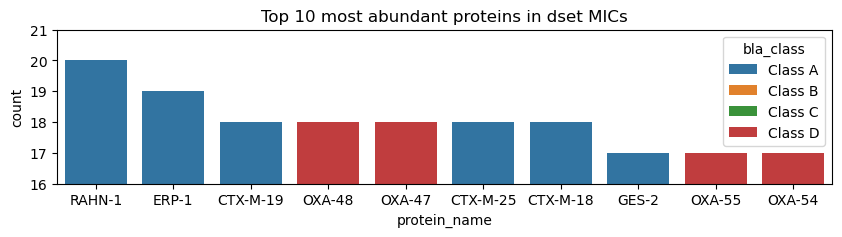

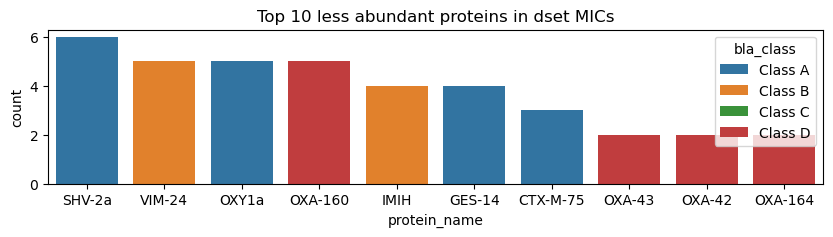

In [16]:
plt.figure(figsize=(10, 2))
sns.countplot(data = df_mics, x = "protein_name", hue = "bla_class", dodge = False,
              order = pd.value_counts(df_mics["protein_name"]).head(10).index)
plt.title("Top 10 most abundant proteins in dset MICs")
plt.xticks(rotation = 0)
plt.ylim(16, 21)

plt.figure(figsize=(10, 2))
sns.countplot(data = df_mics, x = "protein_name",  hue = "bla_class", dodge = False,
              order = pd.value_counts(df_mics["protein_name"]).tail(10).index)
plt.title("Top 10 less abundant proteins in dset MICs")
plt.xticks(rotation = 0)

In [17]:
df_mics.to_csv("../data/bldb2/all_mics_raw.csv", index = False, sep = "\t")
! ls ../data/bldb2/

all_mics_raw.csv  kinetics  mics


## merge dset

In [18]:
# load mics data 
df_mics = pd.read_csv("../data/bldb2/all_mics_raw.csv", sep = "\t")
df_mics.pop("bla_class")
df_mics.head(1)

,protein_name,antibiotic,antibiotic_class,mic_without_bla,mic_with_bla,fold,log2_fold
0,SFO-1,Amoxicillin,Penicillins,1.0,256.0,256.0,8.0


In [19]:
# load plm embeddings
df_plm = pd.read_pickle("../results/embeddings/all_plm.pkl")
df_plm.pop("seq")
df_plm.head(1)

,seq_id,esm1b,esm,onehot,t5xlu50,t5bfd,xlnet,bepler,carp640M,carp640M_logp
0,seq_0,"[0.1102982, 0.014699467, -0.14032564, 0.258299...","[-1.9012868, 0.22372644, 0.21296117, -0.166722...","[0.08450704, 0.024647888, 0.08450704, 0.045774...","[0.008956722, 0.02665889, 0.02402008, 0.014990...","[0.023663048, -0.0007369746, -0.0076412507, 0....","[-0.19811592, 0.051563144, -0.005958873, 0.039...","[0.08450704, 0.045774646, 0.07042254, 0.084507...","[8.911173, 9.043713, 2.4614172, 12.103228, -8....",-0.294909


In [20]:
# load seq annots
df_annot = pd.read_csv("../results/tables/df_annot_all.csv", sep = "\t")
df_annot.head(1)

,#name,seq,length,filename,protein_name,protein_family,bla_class,bla_subclass,protein_family_header,seq_id,...,Species,predicted_signal_peptide,Other_sigpept,SP(Sec/SPI),LIPO(Sec/SPII),TAT(Tat/SPI),TATLIPO(Sec/SPII),PILIN(Sec/SPIII),CS Position,seq_without_sigpept
0,gi|5596421|emb|CAB51471.1|ACI-1| class A exten...,MKKFCFLFLIICGLMVFCLQDCQARQKLNLADLENKYNAVIGVYAV...,284,A-ACI-1-prot.fasta,ACI-1,ACI,Class A,Class A,ACI,seq_0,...,NaN,LIPO,0.000157,0.499448,0.50017,0.000095,0.000088,0.000081,CS pos: 21-22. Pr: 0.4839,CQARQKLNLADLENKYNAVIGVYAVDMENGKKICYKPDTRFSYCST...


In [21]:
#merge anot and pld
df = pd.merge(df_annot, df_plm, on = "seq_id")
df.head(1)

,#name,seq,length,filename,protein_name,protein_family,bla_class,bla_subclass,protein_family_header,seq_id,...,seq_without_sigpept,esm1b,esm,onehot,t5xlu50,t5bfd,xlnet,bepler,carp640M,carp640M_logp
0,gi|5596421|emb|CAB51471.1|ACI-1| class A exten...,MKKFCFLFLIICGLMVFCLQDCQARQKLNLADLENKYNAVIGVYAV...,284,A-ACI-1-prot.fasta,ACI-1,ACI,Class A,Class A,ACI,seq_0,...,CQARQKLNLADLENKYNAVIGVYAVDMENGKKICYKPDTRFSYCST...,"[0.1102982, 0.014699467, -0.14032564, 0.258299...","[-1.9012868, 0.22372644, 0.21296117, -0.166722...","[0.08450704, 0.024647888, 0.08450704, 0.045774...","[0.008956722, 0.02665889, 0.02402008, 0.014990...","[0.023663048, -0.0007369746, -0.0076412507, 0....","[-0.19811592, 0.051563144, -0.005958873, 0.039...","[0.08450704, 0.045774646, 0.07042254, 0.084507...","[8.911173, 9.043713, 2.4614172, 12.103228, -8....",-0.294909


In [22]:
matched_seqs = df[df.protein_name.isin(df_mics.protein_name.unique())]
print(f"A total of {len(matched_seqs.protein_name.unique())} proteins have a match in BLDB seqs")
matched_seqs.protein_name.unique()

A total of 206 proteins have a match in BLDB seqs


array(['AST-1', 'BEL-2', 'BES-1', 'BIC-1', 'CARB-10', 'CTX-M-10',
       'CTX-M-16', 'CTX-M-17', 'CTX-M-19', 'CTX-M-23', 'CTX-M-25',
       'CTX-M-27', 'CTX-M-30', 'CTX-M-32', 'CTX-M-33', 'CTX-M-4',
       'CTX-M-40', 'CTX-M-41', 'CTX-M-45', 'CTX-M-53', 'CTX-M-66',
       'CTX-M-71', 'CTX-M-72', 'CTX-M-75', 'CTX-M-8', 'CTX-M-9',
       'CTX-M-93', 'ERP-1', 'GES-13', 'GES-14', 'GES-18', 'GES-2',
       'GES-3', 'GES-4', 'GES-9', 'KPC-10', 'KPC-4', 'KPC-5', 'LUT-1',
       'PER-2', 'PER-6', 'PME-1', 'RAHN-1', 'RAHN-2', 'SED-1', 'SFO-1',
       'SHV-105', 'SHV-16', 'SHV-24', 'SHV-25', 'SHV-26', 'SHV-2a',
       'SHV-48', 'SHV-49', 'SHV-57', 'SHV-7', 'SHV-70', 'SHV-72',
       'SHV-89', 'SME-1', 'TEM-116', 'TEM-121', 'TEM-125', 'TEM-127',
       'TEM-131', 'TEM-132', 'TEM-134', 'TEM-138', 'TEM-139', 'TEM-141',
       'TEM-149', 'TEM-151', 'TEM-152', 'TEM-155', 'TEM-158', 'TEM-164',
       'TEM-168', 'TEM-187', 'TEM-28', 'TEM-30', 'TEM-43', 'TEM-47',
       'TEM-48', 'TEM-49', 'TEM-52', 'TE

In [23]:
mismatch_seqs = df_mics[~df_mics.protein_name.isin(matched_seqs.protein_name)]
print(f"A total of {len(mismatch_seqs.protein_name.unique())} proteins have NO match in BLDB seqs and need to be checked")
mismatch_seqs.protein_name.unique()

A total of 9 proteins have NO match in BLDB seqs and need to be checked


array(['OXY1a', 'CTX-M-18', 'SHV-84', 'KPC-1', 'TEM-42', 'TEM-59', 'IMIH',
       'MOR', 'OXA-114'], dtype=object)

###  case 1: OXY1a is OXY-1-6

In [24]:
# the accession of Oxy1a seq is Y17715 in BLDB
# https://ifr48.timone.univ-mrs.fr/beta-lactamase/public/betalactamase/searchbetalactamase?requete=OXY
# and mapped this accession Y17715 in BLDB match OXY-1-6 class A seq   
df[df["#name"].str.contains("OXY-1-6")]

,#name,seq,length,filename,protein_name,protein_family,bla_class,bla_subclass,protein_family_header,seq_id,...,seq_without_sigpept,esm1b,esm,onehot,t5xlu50,t5bfd,xlnet,bepler,carp640M,carp640M_logp
11060,gi|4775480|emb|CAB42615.1|OXY-1-6| class A ext...,MLKSSWRKTALMAAAAVPLLLASGSLWASADAIQQKLADLEKRSGG...,291,A-OXY-1-6-prot.fasta,OXY-1-6,OXY,Class A,Class A,OXY,seq_11060,...,SADAIQQKLADLEKRSGGRLGVALINTADDSQTLYRGDERFAMCST...,"[0.12243761, -0.0134811625, -0.1332775, 0.2301...","[-1.5622215, -0.21464717, 0.24915974, 0.043556...","[0.14089347, 0.0034364262, 0.05154639, 0.04467...","[0.008710231, 0.04833396, 0.030574186, 0.02816...","[0.01873947, 0.020568538, -0.022528084, 0.0398...","[-0.40283433, 0.3280856, -0.15147826, -0.32990...","[0.14089347, 0.04467354, 0.03436426, 0.0515463...","[8.341715, 8.269951, 1.7952701, 13.452404, -9....",-0.277631


In [25]:
# also the seq in ncbi match OXY-1-6 in BLDB again
query = "MLKSSWRKTALMAAAAVPLLLASGSLWASADAIQQKLADLEKRSGGRLGVALINTADDSQTLYRGDERFAMCSTGKVMAAAAVLKQSESNPEVVNKRLEIKKSDLVVWSPITEKHLQSGMTLAELSAAALQYSDNTAMNKMISYLGGPEKVTAFAQSIGDVTFRLDRTEPALNSAIPGDKRDTTTPLAMAESLRKLTLGNALGEQQRAQLVTWLKGNTTGGQSIRAGLPASWAVGDKTGAGDYGTTNDIAVIWPENHAPLVPVTYFTQPQQDAKSRKKVLAAAAKIVTEGL"
df[df["seq"].str.contains(query)]

,#name,seq,length,filename,protein_name,protein_family,bla_class,bla_subclass,protein_family_header,seq_id,...,seq_without_sigpept,esm1b,esm,onehot,t5xlu50,t5bfd,xlnet,bepler,carp640M,carp640M_logp
11060,gi|4775480|emb|CAB42615.1|OXY-1-6| class A ext...,MLKSSWRKTALMAAAAVPLLLASGSLWASADAIQQKLADLEKRSGG...,291,A-OXY-1-6-prot.fasta,OXY-1-6,OXY,Class A,Class A,OXY,seq_11060,...,SADAIQQKLADLEKRSGGRLGVALINTADDSQTLYRGDERFAMCST...,"[0.12243761, -0.0134811625, -0.1332775, 0.2301...","[-1.5622215, -0.21464717, 0.24915974, 0.043556...","[0.14089347, 0.0034364262, 0.05154639, 0.04467...","[0.008710231, 0.04833396, 0.030574186, 0.02816...","[0.01873947, 0.020568538, -0.022528084, 0.0398...","[-0.40283433, 0.3280856, -0.15147826, -0.32990...","[0.14089347, 0.04467354, 0.03436426, 0.0515463...","[8.341715, 8.269951, 1.7952701, 13.452404, -9....",-0.277631


###  case 2: CTX-M-18 is (KLUY-1 and CTX-M-14)

In [26]:
# CTX-M-18 are known with next names in BLDB: CTX-M-14 | KLUY-1 | Toho-3 | UOE-2
# http://bldb.eu/BLDB.php?prot=A#CTX-M
df[df["#name"].str.contains("CTX-M-14$")]

,#name,seq,length,filename,protein_name,protein_family,bla_class,bla_subclass,protein_family_header,seq_id,...,seq_without_sigpept,esm1b,esm,onehot,t5xlu50,t5bfd,xlnet,bepler,carp640M,carp640M_logp
10366,ABN64105.1|KLUY-1| class A extended-spectrum b...,MVTKRVQRMMFAAAACIPLLLGSAPLYAQTSAVQQKLAALEKSSGG...,291,A-KLUY-1-prot.fasta,KLUY-1,KLUY,Class A,Class A,KLUY,seq_10366,...,QTSAVQQKLAALEKSSGGRLGVALIDTADNTQVLYRGDERFPMCST...,"[0.12900826, -0.015114538, -0.06845206, 0.1846...","[-1.2543374, -0.14745592, 0.18696815, 0.048153...","[0.14089347, 0.0068728523, 0.04467354, 0.03780...","[0.016168216, 0.051059265, 0.024443002, 0.0402...","[0.040356647, 0.04859177, -0.019211294, 0.0429...","[-0.46855032, 0.28316832, -0.13480753, -0.4068...","[0.14089347, 0.058419243, 0.03780069, 0.044673...","[8.398297, 10.088345, 1.9794176, 13.66585, -8....",-0.216956


In [27]:
# also the seq in ncbi match CTX-M-14 and KLUY-1 in BLDB again
# https://www.ncbi.nlm.nih.gov/protein/AAK55533.1?report=fasta
query = "MVTKRVQRMMFAAAACIPLLLGSAPLYAQTSAVQQKLAALEKSSGGRLGVALIDTADNTQVLYRGDERFPMCSTSKVMAAAAVLKQSETQKQLLNQPVEIKPADLVNYNPIAEKHVNGTMTLAELSAAALQYSDNTAMNKLIAQLGGPGGVTAFARAIGDETFRLDRTEPTLNTAIPGDPRDTTTPRAMAQTLRQLTLGHALGETQRAQLVTWLKGNTTGAASIRAGLPTSWTVGDKTGSGDYGTTNDIAVIWPQGRAPLVLVTYFTQPQQNAESRRDVLASAARIIAEGL"
df[df["seq"].str.contains(query)]

,#name,seq,length,filename,protein_name,protein_family,bla_class,bla_subclass,protein_family_header,seq_id,...,seq_without_sigpept,esm1b,esm,onehot,t5xlu50,t5bfd,xlnet,bepler,carp640M,carp640M_logp
9543,gi|126009707|gb|ABN64105.1|CTX-M-14| Escherich...,MVTKRVQRMMFAAAACIPLLLGSAPLYAQTSAVQQKLAALEKSSGG...,291,A-CTX-M-14-prot.fasta,CTX-M-14,CTX,Class A,Class A,CTX-M,seq_9543,...,QTSAVQQKLAALEKSSGGRLGVALIDTADNTQVLYRGDERFPMCST...,"[0.12900826, -0.015114538, -0.06845206, 0.1846...","[-1.2543374, -0.14745592, 0.18696815, 0.048153...","[0.14089347, 0.0068728523, 0.04467354, 0.03780...","[0.016168216, 0.051059265, 0.024443002, 0.0402...","[0.040356647, 0.04859177, -0.019211294, 0.0429...","[-0.46855032, 0.28316832, -0.13480753, -0.4068...","[0.14089347, 0.058419243, 0.03780069, 0.044673...","[8.398297, 10.088345, 1.9794176, 13.66585, -8....",-0.216956
10366,ABN64105.1|KLUY-1| class A extended-spectrum b...,MVTKRVQRMMFAAAACIPLLLGSAPLYAQTSAVQQKLAALEKSSGG...,291,A-KLUY-1-prot.fasta,KLUY-1,KLUY,Class A,Class A,KLUY,seq_10366,...,QTSAVQQKLAALEKSSGGRLGVALIDTADNTQVLYRGDERFPMCST...,"[0.12900826, -0.015114538, -0.06845206, 0.1846...","[-1.2543374, -0.14745592, 0.18696815, 0.048153...","[0.14089347, 0.0068728523, 0.04467354, 0.03780...","[0.016168216, 0.051059265, 0.024443002, 0.0402...","[0.040356647, 0.04859177, -0.019211294, 0.0429...","[-0.46855032, 0.28316832, -0.13480753, -0.4068...","[0.14089347, 0.058419243, 0.03780069, 0.044673...","[8.398297, 10.088345, 1.9794176, 13.66585, -8....",-0.216956


CTX-M-14 was choosen

###  case 3: SHV-84 is SHV-P11


In [28]:
# SHV-84 is SHV-P11 in BLDB http://bldb.eu/BLDB.php?prot=A#SHV
df[df["#name"].str.contains("SHV-P11")]

,#name,seq,length,filename,protein_name,protein_family,bla_class,bla_subclass,protein_family_header,seq_id,...,seq_without_sigpept,esm1b,esm,onehot,t5xlu50,t5bfd,xlnet,bepler,carp640M,carp640M_logp
12424,"CAJ32371.1|SHV-P11| beta-lactamase, partial [E...",MRYIRLCIISLLATLPLAVHASPQPLEQIKLSESQLSGRVGMIEMD...,277,A-SHV-P11-prot.fasta,SHV-P11,SHV,Class A,Class A,SHV,seq_12424,...,SPQPLEQIKLSESQLSGRVGMIEMDLASGRTLTAWRADERFPMMST...,"[0.12046613, -0.055189285, -0.0906128, 0.24448...","[-1.9584498, -0.26832184, 0.48831558, -0.40919...","[0.12274368, 0.010830325, 0.057761732, 0.05054...","[0.04361709, 0.093091354, 0.035019886, 0.03367...","[0.03904672, 0.0435349, 0.00094740745, 0.02916...","[-0.28578112, 0.2821429, -0.014966411, -0.2253...","[0.12274368, 0.090252705, 0.025270758, 0.05776...","[8.1191635, 10.9739275, 4.896964, 13.892393, -...",-0.217671


###  case 4: KPC-1 is KPC-A10

In [29]:
# KPC-1 are AKA KPC-2 according to http://bldb.eu/BLDB.php?prot=A#KPC
df[df["protein_name"].str.contains("KPC-2$", na = False)]

,#name,seq,length,filename,protein_name,protein_family,bla_class,bla_subclass,protein_family_header,seq_id,...,seq_without_sigpept,esm1b,esm,onehot,t5xlu50,t5bfd,xlnet,bepler,carp640M,carp640M_logp
10388,gi|1039280605|gb|OBR18659.1|KPC-2| carbapenem-...,MSLYRRLVLLSCLSWPLAGFSATALTNLVAEPFAKLEQDFGGSIGV...,293,A-KPC-2-prot.fasta,KPC-2,KPC,Class A,Class A,KPC,seq_10388,...,FSATALTNLVAEPFAKLEQDFGGSIGVYAMDTGSGATVSYRAEERF...,"[0.11546305, -0.047619086, -0.05431689, 0.2468...","[-1.5562196, -0.14438231, 0.31671926, -0.08633...","[0.15017065, 0.010238908, 0.04778157, 0.040955...","[0.028476533, 0.026355999, 0.013787666, 0.0233...","[0.0242128, 0.004736292, -0.036256384, 0.01518...","[-0.3498813, 0.17523022, -0.18281725, -0.28961...","[0.15017065, 0.058020476, 0.034129694, 0.04778...","[9.543109, 9.685027, 3.501294, 12.908332, -7.8...",-0.2376


In [30]:
# but the sequence in BLDB2 match KPC-A10: https://www.ncbi.nlm.nih.gov/protein/AAG13410.1?report=fasta
query = "MSLYRRLVLLSCLSWPLAGFSATALTNLVAEPFAKLEQDFGGSIGVYAMDTGSGATVSYRAEERFPLCSSFKGFLAAAVLARSQQQAGLLDTPIRYGKNALVPWSPISEKYLTTGMTVAELSAAAVQYSDNAAANLLLKELGGPAGLTAFMRSIGDTTFRLDRWELELNSAIPSDARDTSSPRAVTESLQKLTLGSALAAPQRQQFVDWLKGNTTGNHRIRAAVPADWAVGDKTGTCGVYGTANDYAVVWPTGRAPIVLAVYTRAPNKDDKHSEAVIAAAARLALEGLGVNGQ" 
df[df["seq"].str.contains(query)]

,#name,seq,length,filename,protein_name,protein_family,bla_class,bla_subclass,protein_family_header,seq_id,...,seq_without_sigpept,esm1b,esm,onehot,t5xlu50,t5bfd,xlnet,bepler,carp640M,carp640M_logp
10468,AAG13410.1|KPC-A10| carbepenem-hydrolyzing bet...,MSLYRRLVLLSCLSWPLAGFSATALTNLVAEPFAKLEQDFGGSIGV...,293,A-KPC-A10-prot.fasta,KPC-A10,KPC,Class A,Class A,KPC,seq_10468,...,FSATALTNLVAEPFAKLEQDFGGSIGVYAMDTGSGATVSYRAEERF...,"[0.11643823, -0.045800727, -0.053713605, 0.246...","[-1.5865532, -0.13218787, 0.321467, -0.0818219...","[0.15017065, 0.010238908, 0.04778157, 0.040955...","[0.028633846, 0.025913658, 0.01323355, 0.02371...","[0.023163639, 0.0044065374, -0.03816928, 0.017...","[-0.3475553, 0.1754662, -0.18888642, -0.293144...","[0.15017065, 0.058020476, 0.034129694, 0.04778...","[9.496655, 9.628242, 3.4424036, 12.845525, -7....",-0.245853


Both seqs have 293aa, but differ in one aminoacid

- ncbi seq: S174
- BLDB (KPC-2) seq: G174

In order to follow the seqs in BLDB2, the seq in ncbi has preference, and therefore, KPC-1 is KPC-A10

###  case 5: TEM-42 is TEM-P116

In [31]:
# TEM-42 is TEM-P116 according to
# http://bldb.eu/BLDB.php?prot=A#TEM
df[df["#name"].str.contains("TEM-P116")]

,#name,seq,length,filename,protein_name,protein_family,bla_class,bla_subclass,protein_family_header,seq_id,...,seq_without_sigpept,esm1b,esm,onehot,t5xlu50,t5bfd,xlnet,bepler,carp640M,carp640M_logp
12841,"CAA66659.1|TEM-P116| beta-lactamase, partial (...",QHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDKLGVRVGYIELDL...,281,A-TEM-P116-prot.fasta,TEM-P116,TEM,Class A,Class A,TEM,seq_12841,...,HPETLVKVKDAEDKLGVRVGYIELDLNSGKILESFRPEERFPMMST...,"[0.09771571, -0.028099218, -0.11751115, 0.2367...","[-1.9762262, -0.26676863, 0.2662039, -0.560335...","[0.099644125, 0.010676157, 0.0569395, 0.067615...","[0.05149815, 0.10120242, 0.024426049, 0.051567...","[0.056459833, 0.06716549, 0.017756777, 0.04512...","[-0.25316805, 0.26089898, 0.023713296, -0.2540...","[0.099644125, 0.06761566, 0.02846975, 0.056939...","[9.134323, 10.189747, 4.3122206, 15.397975, -7...",-0.228212


In [32]:
# also the seq in ncbi match TEM-P116 again
query = "QHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDKLGVRVGYIELDLNSGKILESFRPEERFPMMSTFKVLLCGAVLSRVDAGQEQLGRRIHYSQNDLVEYSPVTEKHLTDGMTVRELCSAAITMSDNTAANLLLTTIGGPKELTAFLHNMGDHVTRLDRWEPELNEAIPNDERDTTMPAAMATTLRKLLTGELLTLASRQQLIDWMEADKVAGPLLRSALPAGWFIADKSGASKRGSRGIIAALGPDGKPSRIVVIYMTGSQATMDERNRQIAEIGASLIK"
df[df["seq"].str.contains(query)]

,#name,seq,length,filename,protein_name,protein_family,bla_class,bla_subclass,protein_family_header,seq_id,...,seq_without_sigpept,esm1b,esm,onehot,t5xlu50,t5bfd,xlnet,bepler,carp640M,carp640M_logp
12841,"CAA66659.1|TEM-P116| beta-lactamase, partial (...",QHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDKLGVRVGYIELDL...,281,A-TEM-P116-prot.fasta,TEM-P116,TEM,Class A,Class A,TEM,seq_12841,...,HPETLVKVKDAEDKLGVRVGYIELDLNSGKILESFRPEERFPMMST...,"[0.09771571, -0.028099218, -0.11751115, 0.2367...","[-1.9762262, -0.26676863, 0.2662039, -0.560335...","[0.099644125, 0.010676157, 0.0569395, 0.067615...","[0.05149815, 0.10120242, 0.024426049, 0.051567...","[0.056459833, 0.06716549, 0.017756777, 0.04512...","[-0.25316805, 0.26089898, 0.023713296, -0.2540...","[0.099644125, 0.06761566, 0.02846975, 0.056939...","[9.134323, 10.189747, 4.3122206, 15.397975, -7...",-0.228212


###  case 6: TEM-59 is TEM-P114

In [33]:
# TEM-59 are TEM-P114 in BLDB1
df[df["protein_name"].str.contains("TEM-P114", na = False)]

,#name,seq,length,filename,protein_name,protein_family,bla_class,bla_subclass,protein_family_header,seq_id,...,seq_without_sigpept,esm1b,esm,onehot,t5xlu50,t5bfd,xlnet,bepler,carp640M,carp640M_logp
12839,AAD45935.1|TEM-P114| inhibitor-resistant beta-...,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDKLGARVGYIE...,277,A-TEM-P114-prot.fasta,TEM-P114,TEM,Class A,Class A,TEM,seq_12839,...,HPETLVKVKDAEDKLGARVGYIELDLNSGKILESFRPEERFPMMST...,"[0.10780813, -0.029796751, -0.12344802, 0.2370...","[-2.0601451, -0.234945, 0.32767883, -0.5359882...","[0.10108303, 0.010830325, 0.057761732, 0.07220...","[0.03913932, 0.097339384, 0.036502004, 0.04242...","[0.05008751, 0.05454172, 0.017690245, 0.041251...","[-0.26099303, 0.2733927, 0.06458734, -0.185037...","[0.10108303, 0.06859206, 0.028880866, 0.057761...","[8.847932, 10.509344, 4.2913647, 14.922517, -8...",-0.212499


In [34]:
# also its seq match the same TEM-P114
query = "MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDKLGARVGYIELDLNSGKILESFRPEERFPMMSTFKVLLCGAVLSRVDAGQEQLGRRIHYSQNDLVEYSPVTEKHLTDGMTVRELCSAAITMGDNTAANLLLTTIGGPKELTAFLHNMGDHVTRLDRWEPELNEAIPNDERDTTMPAAMATTLRKLLTGELLTLASRQQLIDWMEADKVAGPLLRSALPAGWFIADKSGAGERGSRGIIAALGPDGKPSRIVVIYTTGSQATMDERNRQIAE"
df[df["seq"].str.contains(query)]

,#name,seq,length,filename,protein_name,protein_family,bla_class,bla_subclass,protein_family_header,seq_id,...,seq_without_sigpept,esm1b,esm,onehot,t5xlu50,t5bfd,xlnet,bepler,carp640M,carp640M_logp
12839,AAD45935.1|TEM-P114| inhibitor-resistant beta-...,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDKLGARVGYIE...,277,A-TEM-P114-prot.fasta,TEM-P114,TEM,Class A,Class A,TEM,seq_12839,...,HPETLVKVKDAEDKLGARVGYIELDLNSGKILESFRPEERFPMMST...,"[0.10780813, -0.029796751, -0.12344802, 0.2370...","[-2.0601451, -0.234945, 0.32767883, -0.5359882...","[0.10108303, 0.010830325, 0.057761732, 0.07220...","[0.03913932, 0.097339384, 0.036502004, 0.04242...","[0.05008751, 0.05454172, 0.017690245, 0.041251...","[-0.26099303, 0.2733927, 0.06458734, -0.185037...","[0.10108303, 0.06859206, 0.028880866, 0.057761...","[8.847932, 10.509344, 4.2913647, 14.922517, -8...",-0.212499


###  case 7: IMIH is CphA-13

In [35]:
# IMIH are not in BLDB
# https://ifr48.timone.univ-mrs.fr/beta-lactamase/public/betalactamase/searchbetalactamase?requete=IMIH
# but its seq match CphA-13
query = "MMKGWMKCGLAGAVVLMASFWGGSVRAAGMSLTQVSGPVYVVEDNYYVQENSMVYFGAKGVTVVGATWTPDTARELHKLIKRVSRQPVLEVINTNYHTDRAGGNAYWKSIGAKVVSTRQTRDLMKSDWAEIVAFTRKGLPEYPDLPLVLPNVVHDGDFTLQEGKLRAFYAGPAHTPDGIFVYFPDQLVLYGNCILKEKLGNLSFADVKAYPQTLERLKAMKLPIKTVVGGHDSPLHGPELIDHYEALIKAAPQS"
df[df["seq"].str.contains(query)]

,#name,seq,length,filename,protein_name,protein_family,bla_class,bla_subclass,protein_family_header,seq_id,...,seq_without_sigpept,esm1b,esm,onehot,t5xlu50,t5bfd,xlnet,bepler,carp640M,carp640M_logp
14566,CAD69003.1|CphA-13| ChpA family subclass B2 me...,MMKGWMKCGLAGAVVLMASFWGGSVRAAGMSLTQVSGPVYVVEDNY...,254,B2-CphA-13-prot.fasta,CphA-13,CphA,Class B,Class B2,CphA,seq_14566,...,AGMSLTQVSGPVYVVEDNYYVQENSMVYFGAKGVTVVGATWTPDTA...,"[0.012015472, 0.1560463, 0.025601689, 0.007290...","[-1.755281, -0.5171106, 0.7061019, 0.161125, -...","[0.08661418, 0.007874016, 0.051181104, 0.04330...","[-0.0028778426, 0.012281899, 0.0042176107, 0.0...","[0.0034713496, 0.0009490037, 0.020942667, -0.0...","[-0.05526233, 0.025119454, 0.09593754, -0.1064...","[0.08661418, 0.03937008, 0.031496063, 0.051181...","[8.027961, 8.913769, -0.89448106, 9.236223, -1...",-0.356209


###  case 8: MOR is DHA-21

In [36]:
# MOR https://ifr48.timone.univ-mrs.fr/beta-lactamase/public/betalactamase/searchbetalactamase?requete=MOR 
# match DHA-21
query = "MKKSLSATLISALLAFSAPGFSAADNVAAVVDSTIKPLMAQQDIPGMAVAVSVKGKPYYFNYGFADVQAKQPVTENTLFELGSVSKTFTGVLGAVSVAKKEMTLNDPAEKYQPELALPQWKGITLLDLATYTAGGLPLQVPDAVKSRADLLHFYQQWQPSRKPGDMRLYANSSIGLFGALTANAAGMPYEQLLTARILAPLGLSHTFITVPESAQSQYAYGYKNKKPVRVSPGQLDAESYGVKSASKDMLRWAEMNMEPSRAGNADLEMAMYLAQTRYYKTAAINQGLGWEMYDWPQQKDMIINGVTNEVALQPHPVTDNQVQPYNRASWVHKTGATTGFGAYVAFIPEKQVAIVILANKNYPNTERVKAAQAILSALE"
df[df["seq"].str.contains(query)]

,#name,seq,length,filename,protein_name,protein_family,bla_class,bla_subclass,protein_family_header,seq_id,...,seq_without_sigpept,esm1b,esm,onehot,t5xlu50,t5bfd,xlnet,bepler,carp640M,carp640M_logp
18461,gi|698174186|gb|AIT76100.1|DHA-21| class C bet...,MKKSLSATLISALLAFSAPGFSAADNVAAVVDSTIKPLMAQQDIPG...,379,C-DHA-21-prot.fasta,DHA-21,DHA,Class C,Class C,DHA,seq_18461,...,AADNVAAVVDSTIKPLMAQQDIPGMAVAVSVKGKPYYFNYGFADVQ...,"[0.11681807, 0.17636302, -0.04386956, 0.046236...","[-0.22171102, 0.14071436, 0.2161965, -0.541968...","[0.13192612, 0.0, 0.039577838, 0.04221636, 0.0...","[0.02752532, 0.06819231, 0.028910216, 0.016251...","[0.032883797, 0.0256175, -0.020755084, 0.04235...","[-0.14694875, 0.26925611, 0.053444996, 0.00399...","[0.13192612, 0.026385223, 0.044854883, 0.03957...","[9.477676, 3.7405617, 2.495018, 12.018888, -11...",-0.320542


### case 9: OXA-114 is OXA-114a

In [37]:
# there are 26 seqs OXA-14[a,b,c,d ...w]
df[df["#name"].str.contains("OXA-114")]["protein_name"]

23308    OXA-114a
23309    OXA-114b
23310    OXA-114c
23311    OXA-114d
23312    OXA-114e
23313    OXA-114f
23314    OXA-114g
23315    OXA-114h
23316    OXA-114i
23317    OXA-114j
23318    OXA-114k
23319    OXA-114l
23320    OXA-114m
23321    OXA-114n
23322    OXA-114p
23323    OXA-114q
23324    OXA-114r
23325    OXA-114s
23326    OXA-114t
23327    OXA-114u
23328    OXA-114v
23329    OXA-114w
23330    OXA-114x
24038     OXA-790
24039     OXA-791
24089     OXA-839
Name: protein_name, dtype: object

In [38]:
# but only OXA-114a match the seq in BLDB2
# https://ifr48.timone.univ-mrs.fr/beta-lactamase/public/betalactamase/searchbetalactamase?requete=OXA
query = "MTVRRLSCALGAALSLSALGGGPVQAAVLCTVVADAADGRILFQQGTQQACAERYTPASTFKLAIALMGADAGILQGPHEPVWNYQPAYPDWGGDAWRQPTDPARWIKYSVVWYSQLTAKALGQDRFQRYTSAFGYGNADVSGEPGKHNGTDGAWIISSLRISPLEQLAFLRKLVNRQLPVKAAAYELAENLFEAGQADGWRLYGKTGTGSPGSNGVYTAANAYGWFVGWARKDGRQLVYARLLQDERATRPNAGLRARDELVRDWPAMAGAWRP"
df[df["seq"].str.contains(query)]

,#name,seq,length,filename,protein_name,protein_family,bla_class,bla_subclass,protein_family_header,seq_id,...,seq_without_sigpept,esm1b,esm,onehot,t5xlu50,t5bfd,xlnet,bepler,carp640M,carp640M_logp
23308,gi|928717439|emb|CUK04783.1|OXA-114a| oxacilli...,MTVRRLSCALGAALSLSALGGGPVQAAVLCTVVADAADGRILFQQG...,275,D-OXA-114a-prot.fasta,OXA-114a,OXA,Class D,Class D,OXA,seq_23308,...,AVLCTVVADAADGRILFQQGTQQACAERYTPASTFKLAIALMGADA...,"[0.080275886, 0.1429358, -0.030849215, 0.13581...","[-0.7645539, 0.016044773, -0.072433785, -0.657...","[0.15272728, 0.010909091, 0.05090909, 0.032727...","[-0.00066321465, 0.021739906, 0.029791381, 0.0...","[0.042637542, -0.03071857, -0.029450638, 0.005...","[-0.2338412, -0.017138286, -0.13579924, -0.226...","[0.15272728, 0.07636364, 0.02909091, 0.0509090...","[6.9496503, 11.130276, 2.1518965, 8.346069, -9...",-0.275814


### resolution

In [39]:
# rename mics dset
df_mics_renamed = df_mics

# rename mics dset 
df_mics_renamed["protein_name"].replace({
    "OXY1a":"OXY-1-6",
    "CTX-M-18":"CTX-M-14",
    "SHV-84":"SHV-P11",
    "KPC-1":"KPC-A10",
    "TEM-42":"TEM-P116",
    "TEM-59":"TEM-P114",
    "IMIH":"CphA-13",
    "MOR":"DHA-21",
    "OXA-114":"OXA-114a"
}, inplace=True)

df_mics_renamed

,protein_name,antibiotic,antibiotic_class,mic_without_bla,mic_with_bla,fold,log2_fold
0,SFO-1,Amoxicillin,Penicillins,1.000,256.00,256.00000,8.000000
1,SFO-1,Amoxicillin-CLA,Penicillins,2.000,256.00,128.00000,7.000000
2,SFO-1,Ceftazidime,Cephalosporins,0.125,16.00,128.00000,7.000000
3,SFO-1,Piperacillin,Penicillins,0.500,256.00,512.00000,9.000000
4,SFO-1,Imipenem,Carbapenems,0.250,0.50,2.00000,1.000000
...,...,...,...,...,...,...,...
2378,OXA-97,Ampicillin,Penicillins,4.000,512.00,128.00000,7.000000
2379,OXA-97,Imipenem,Carbapenems,0.060,1.00,16.66670,4.058897
2380,OXA-97,Ticarcillin,Penicillins,4.000,512.00,128.00000,7.000000
2381,OXA-97,Meropenem,Carbapenems,0.060,0.50,8.33333,3.058893


In [40]:
df_train = pd.merge(df_mics_renamed, df, on ="protein_name")
df_train.to_pickle("../results/mics/training_dset_mics.pkl")
df_train.head(1)

,protein_name,antibiotic,antibiotic_class,mic_without_bla,mic_with_bla,fold,log2_fold,#name,seq,length,...,seq_without_sigpept,esm1b,esm,onehot,t5xlu50,t5bfd,xlnet,bepler,carp640M,carp640M_logp
0,SFO-1,Amoxicillin,Penicillins,1.0,256.0,256.0,8.0,gi|226440723|gb|ACO57221.1|SFO-1| class A exte...,MVKNTLRQTTLMVATVMPLLFGSAPLWAQSANAKANIQQQLSELEK...,295,...,QSANAKANIQQQLSELEKNSGGRLGVALIDTADNSQILYRGDERFP...,"[0.12884726, -0.014014147, -0.14221768, 0.2163...","[-1.3039657, 0.1604022, 0.17407279, 0.09927225...","[0.1220339, 0.0033898305, 0.050847456, 0.04745...","[0.015114492, 0.04356348, 0.019283863, 0.03084...","[0.0176283, 0.018968944, -0.04833036, 0.040485...","[-0.46188685, 0.24787414, -0.09181613, -0.2707...","[0.1220339, 0.040677965, 0.050847456, 0.050847...","[9.180886, 8.3046465, 2.616951, 13.753964, -8....",-0.227483


#  Data source Kinetics 

## load kinetics data 

In [41]:
#load data
kinetics_a = pd.read_csv("../data/bldb2/kinetics/class_a_kinetics.csv")
kinetics_a["bla_class"] = "Class A"
kinetics_b = pd.read_csv("../data/bldb2/kinetics/class_b_kinetics.csv")
kinetics_b["bla_class"] = "Class B"
kinetics_c = pd.read_csv("../data/bldb2/kinetics/class_c_kinetics.csv")
kinetics_c["bla_class"] = "Class C"
kinetics_d = pd.read_csv("../data/bldb2/kinetics/class_d_kinetics.csv")
kinetics_d["bla_class"] = "Class D"

# concat data 
kinetics_all = pd.concat([kinetics_a, kinetics_b, kinetics_c, kinetics_d])
kinetics_all.head(1)

,protein_name,antibiotic,kcat,km,catalytic_efficiency,bla_class
0,TEM-109,Amoxicillin,66±3,15±1,4,Class A


[Text(0, 0, '1'),
 Text(0, 0, '1'),
 Text(0, 0, '3'),
 Text(0, 0, '7'),
 Text(0, 0, '9'),
 Text(0, 0, '12'),
 Text(0, 0, '13'),
 Text(0, 0, '14'),
 Text(0, 0, '24'),
 Text(0, 0, '24'),
 Text(0, 0, '27'),
 Text(0, 0, '36'),
 Text(0, 0, '40'),
 Text(0, 0, '40'),
 Text(0, 0, '44'),
 Text(0, 0, '51'),
 Text(0, 0, '54'),
 Text(0, 0, '54'),
 Text(0, 0, '58'),
 Text(0, 0, '63'),
 Text(0, 0, '64'),
 Text(0, 0, '69'),
 Text(0, 0, '76'),
 Text(0, 0, '80'),
 Text(0, 0, '91'),
 Text(0, 0, '95'),
 Text(0, 0, '106')]

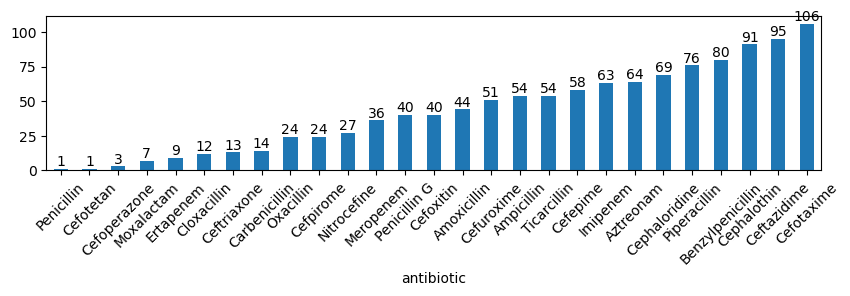

In [42]:
plt.figure(figsize=(10,2)) 
ax = kinetics_all.groupby("antibiotic").count().sort_values("bla_class").iloc[:,0].plot.bar()
plt.xticks(rotation=45)
ax.bar_label(ax.containers[0], size=10)

/home/gama/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0, 0, '634'), Text(0, 0, '185'), Text(0, 0, '99'), Text(0, 0, '238')]

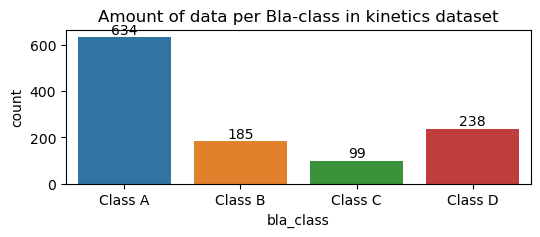

In [43]:
plt.figure(figsize=(6,2)) 
ax = sns.countplot(kinetics_all.bla_class)
plt.title("Amount of data per Bla-class in kinetics dataset")
ax.bar_label(ax.containers[0], size=10)

In [44]:
# add antibiotic class
penicillins_kins = [
    "Amoxicillin","Benzylpenicillin", "Cloxacillin", "Oxacillin","Ticarcillin","Piperacillin", 
    "Carbenicillin", "Penicillin G", "Penicillin" ,"Ampicillin"
]

cephalosporins_kins = [
    "Cephalothin", "Cefuroxime", "Cephalothin","Ceftazidime","Cefotaxime",  "Cefepime", "Cefpirome", 
    "Cephaloridine", "Ceftriaxone", "Nitrocefine", "Cefoxitin", "Cefoperazone", "Cefotetan"
]

carbapenems_kins = ["Imipenem","Meropenem", "Ertapenem"]

monobactams_kins = ["Aztreonam","Moxalactam"]

# add antibiotic class
filters = [
    kinetics_all.antibiotic.str.contains('|'.join(penicillins_kins)), 
    kinetics_all.antibiotic.str.contains('|'.join(cephalosporins_kins)),
    kinetics_all.antibiotic.str.contains('|'.join(carbapenems_kins)),
    kinetics_all.antibiotic.str.contains('|'.join(monobactams_kins))
]

values = ["Penicillins", "Cephalosporins", "Carbapenems", "Monobactams"]

kinetics_all["antibiotic_class"] = np.select(filters, values)

# reorder
kinetics_all = kinetics_all[[
    'protein_name', 'bla_class', 'antibiotic', 'antibiotic_class', 'kcat', 'km', 'catalytic_efficiency']]
kinetics_all

,protein_name,bla_class,antibiotic,antibiotic_class,kcat,km,catalytic_efficiency
0,TEM-109,Class A,Amoxicillin,Penicillins,66±3,15±1,4
1,TEM-109,Class A,Cefuroxime,Cephalosporins,22±3,93±7,0.2
2,TEM-109,Class A,Ticarcillin,Penicillins,42±2,14±2,3
3,TEM-109,Class A,Benzylpenicillin,Penicillins,171±2,20±2,8
4,TEM-109,Class A,Piperacillin,Penicillins,152±10,64±4,2
...,...,...,...,...,...,...,...
233,OXA-63,Class D,Ampicillin,Penicillins,6.6,43,0.15
234,OXA-63,Class D,Benzylpenicillin,Penicillins,4.9,19,0.25
235,OXA-63,Class D,Oxacillin,Penicillins,113,115,0.98
236,OXA-63,Class D,Carbenicillin,Penicillins,1.1,17,0.07


[Text(0, 0, '71'), Text(0, 0, '108'), Text(0, 0, '399'), Text(0, 0, '578')]

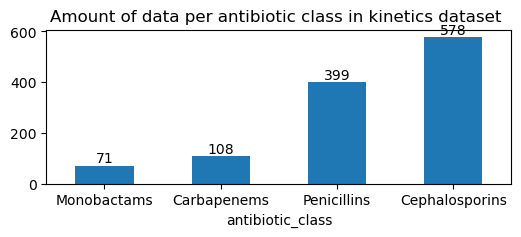

In [45]:
plt.figure(figsize=(6,2)) 
ax = kinetics_all.groupby("antibiotic_class").count().sort_values("bla_class").iloc[:,0].plot.bar()
plt.xticks(rotation=0)
plt.title("Amount of data per antibiotic class in kinetics dataset ")
ax.bar_label(ax.containers[0], size=10)

In [46]:
# remove cols with nan
kinetics_all_clean = kinetics_all.replace(r'^s*$', float('NaN'), regex = True)  # Replace blanks by nans
kinetics_all_clean.dropna(inplace = True) # remove data with nans
kinetics_all_clean

,protein_name,bla_class,antibiotic,antibiotic_class,kcat,km,catalytic_efficiency
0,TEM-109,Class A,Amoxicillin,Penicillins,66±3,15±1,4
1,TEM-109,Class A,Cefuroxime,Cephalosporins,22±3,93±7,0.2
2,TEM-109,Class A,Ticarcillin,Penicillins,42±2,14±2,3
3,TEM-109,Class A,Benzylpenicillin,Penicillins,171±2,20±2,8
4,TEM-109,Class A,Piperacillin,Penicillins,152±10,64±4,2
...,...,...,...,...,...,...,...
233,OXA-63,Class D,Ampicillin,Penicillins,6.6,43,0.15
234,OXA-63,Class D,Benzylpenicillin,Penicillins,4.9,19,0.25
235,OXA-63,Class D,Oxacillin,Penicillins,113,115,0.98
236,OXA-63,Class D,Carbenicillin,Penicillins,1.1,17,0.07


In [47]:
# replace > and < chars
kinetics_all_clean.replace({
    'kcat': {'>': '', '<': ''}, 
    'km': {'>': '', '<': ''},
    'catalytic_efficiency': {'>': '', '<': ''}
}, regex=True, inplace=True)

In [48]:
# split all vals with ± symbol and take the first number
kinetics_all_clean["kcat"] = kinetics_all_clean["kcat"].str.split('±').str[0]
kinetics_all_clean["km"] = kinetics_all_clean["km"].str.split('±').str[0]
kinetics_all_clean["catalytic_efficiency"] = kinetics_all_clean["catalytic_efficiency"].str.split('±').str[0]

kinetics_all_clean.to_csv("../results/kinetics/kinetics_dset_clean.csv", index = False)
kinetics_all_clean                             

,protein_name,bla_class,antibiotic,antibiotic_class,kcat,km,catalytic_efficiency
0,TEM-109,Class A,Amoxicillin,Penicillins,66,15,4
1,TEM-109,Class A,Cefuroxime,Cephalosporins,22,93,0.2
2,TEM-109,Class A,Ticarcillin,Penicillins,42,14,3
3,TEM-109,Class A,Benzylpenicillin,Penicillins,171,20,8
4,TEM-109,Class A,Piperacillin,Penicillins,152,64,2
...,...,...,...,...,...,...,...
233,OXA-63,Class D,Ampicillin,Penicillins,6.6,43,0.15
234,OXA-63,Class D,Benzylpenicillin,Penicillins,4.9,19,0.25
235,OXA-63,Class D,Oxacillin,Penicillins,113,115,0.98
236,OXA-63,Class D,Carbenicillin,Penicillins,1.1,17,0.07


/home/gama/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0, 0, '460'), Text(0, 0, '176'), Text(0, 0, '61'), Text(0, 0, '146')]

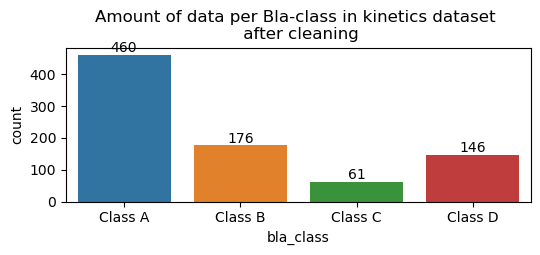

In [64]:
plt.figure(figsize=(6,2)) 
ax = sns.countplot(kinetics_all_clean.bla_class)
plt.title("Amount of data per Bla-class in kinetics dataset \n after cleaning")
ax.bar_label(ax.containers[0], size=10)

[Text(0, 0, '2'),
 Text(0, 0, '4'),
 Text(0, 0, '8'),
 Text(0, 0, '8'),
 Text(0, 0, '10'),
 Text(0, 0, '11'),
 Text(0, 0, '16'),
 Text(0, 0, '20'),
 Text(0, 0, '20'),
 Text(0, 0, '25'),
 Text(0, 0, '29'),
 Text(0, 0, '29'),
 Text(0, 0, '36'),
 Text(0, 0, '38'),
 Text(0, 0, '40'),
 Text(0, 0, '40'),
 Text(0, 0, '41'),
 Text(0, 0, '42'),
 Text(0, 0, '44'),
 Text(0, 0, '46'),
 Text(0, 0, '60'),
 Text(0, 0, '63'),
 Text(0, 0, '64'),
 Text(0, 0, '73'),
 Text(0, 0, '74')]

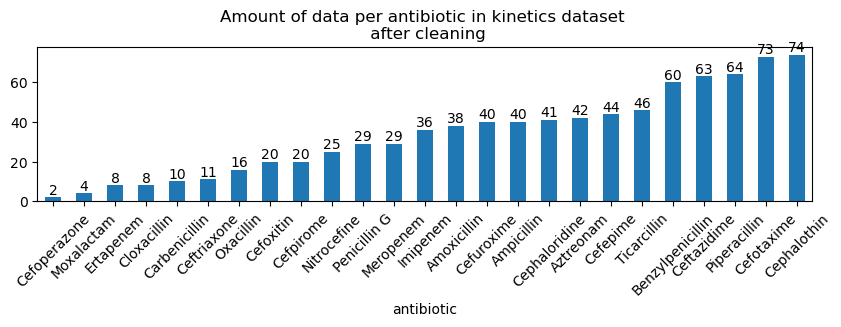

In [65]:
plt.figure(figsize=(10,2)) 
ax = kinetics_all_clean.groupby("antibiotic").count().sort_values("bla_class").iloc[:,0].plot.bar()
plt.xticks(rotation=45)
plt.title("Amount of data per antibiotic in kinetics dataset \n after cleaning")
ax.bar_label(ax.containers[0], size=10)

[Text(0, 0, '46'), Text(0, 0, '73'), Text(0, 0, '311'), Text(0, 0, '413')]

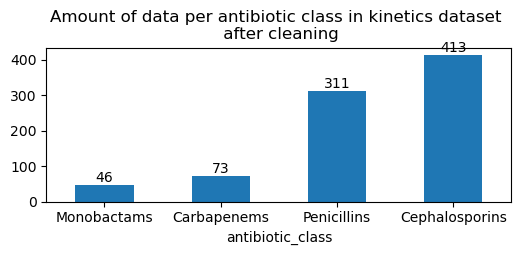

In [66]:
plt.figure(figsize=(6,2)) 
ax = kinetics_all_clean.groupby("antibiotic_class").count().sort_values("bla_class").iloc[:,0].plot.bar()
plt.xticks(rotation=0)
plt.title("Amount of data per antibiotic class in kinetics dataset \n after cleaning")
ax.bar_label(ax.containers[0], size=10)

## merge dsets 

In [49]:
# load kineteics
kinetics_all_clean = pd.read_csv("../results/kinetics/kinetics_dset_clean.csv")

# load plm embeddings
df_plm = pd.read_pickle("../results/embeddings/all_plm.pkl")
df_plm.pop("seq")
df_plm.head(1)

# load seq annots
df_annot = pd.read_csv("../results/tables/df_annot_all.csv", sep = "\t")
df_annot.head(1)

#merge anot and pld
df = pd.merge(df_annot, df_plm, on = "seq_id")
df.head(1)

,#name,seq,length,filename,protein_name,protein_family,bla_class,bla_subclass,protein_family_header,seq_id,...,seq_without_sigpept,esm1b,esm,onehot,t5xlu50,t5bfd,xlnet,bepler,carp640M,carp640M_logp
0,gi|5596421|emb|CAB51471.1|ACI-1| class A exten...,MKKFCFLFLIICGLMVFCLQDCQARQKLNLADLENKYNAVIGVYAV...,284,A-ACI-1-prot.fasta,ACI-1,ACI,Class A,Class A,ACI,seq_0,...,CQARQKLNLADLENKYNAVIGVYAVDMENGKKICYKPDTRFSYCST...,"[0.1102982, 0.014699467, -0.14032564, 0.258299...","[-1.9012868, 0.22372644, 0.21296117, -0.166722...","[0.08450704, 0.024647888, 0.08450704, 0.045774...","[0.008956722, 0.02665889, 0.02402008, 0.014990...","[0.023663048, -0.0007369746, -0.0076412507, 0....","[-0.19811592, 0.051563144, -0.005958873, 0.039...","[0.08450704, 0.045774646, 0.07042254, 0.084507...","[8.911173, 9.043713, 2.4614172, 12.103228, -8....",-0.294909


In [50]:
match_kin = df[df.protein_name.isin(kinetics_all_clean.protein_name.unique())]
mismatch_kin = kinetics_all_clean[~kinetics_all_clean.protein_name.isin(df.protein_name.unique())]

print(f"A total of {len(match_kin.protein_name.unique())} proteins have a match in BLDB seqs")
print(f"A total of {len(mismatch_kin.protein_name.unique())} proteins NO have a match in BLDB seqs. Mismatch seqs:")
mismatch_kin.protein_name.unique()

A total of 94 proteins have a match in BLDB seqs
A total of 7 proteins NO have a match in BLDB seqs. Mismatch seqs:


array(['TEM-89', 'SHV-84', 'HugA-1', 'HERA-1', 'CTX-M-18', 'L-1',
       'OXA-114'], dtype=object)

Again we know that:
- SHV-84 is SHV-P11
- CTX-M-18 is CTX-M-14
- OXA-114 is OXA-114a

The next seqs have to be checked:
- TEM-89
- HugA-1
- HERA-1
- L-1
       

In [51]:
# TEM-89 is TEM-P120
df[df["#name"].str.contains("TEM-89")]

,#name,seq,length,filename,protein_name,protein_family,bla_class,bla_subclass,protein_family_header,seq_id,...,seq_without_sigpept,esm1b,esm,onehot,t5xlu50,t5bfd,xlnet,bepler,carp640M,carp640M_logp
12846,"AAK71474.1|TEM-P120| TEM-89 beta-lactamase, pa...",MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDKLGARVGYIE...,278,A-TEM-P120-prot.fasta,TEM-P120,TEM,Class A,Class A,TEM,seq_12846,...,HPETLVKVKDAEDKLGARVGYIELDLNSGKILESFRPEERFPMMST...,"[0.115295984, -0.025855985, -0.12562935, 0.236...","[-2.0076225, -0.25508508, 0.29279584, -0.51589...","[0.10071942, 0.010791367, 0.05755396, 0.068345...","[0.038933214, 0.09726143, 0.035671618, 0.04260...","[0.049337212, 0.056580536, 0.015739884, 0.0414...","[-0.24707223, 0.26564124, 0.05630651, -0.22837...","[0.10071942, 0.06834532, 0.02877698, 0.0575539...","[8.868794, 10.462776, 4.306968, 15.131395, -8....",-0.219924


In [52]:
# HugA-1 with accession (AF324468) in BLDB2 maps to HugA (accession AAL57765.1)
df[df["#name"].str.contains("AAL57765.1")]

,#name,seq,length,filename,protein_name,protein_family,bla_class,bla_subclass,protein_family_header,seq_id,...,seq_without_sigpept,esm1b,esm,onehot,t5xlu50,t5bfd,xlnet,bepler,carp640M,carp640M_logp
10316,gi|18041936|gb|AAL57765.1|HugA| class A beta-l...,MFKKTFRQTAAIAVSLISLLASATLWANTNNTIEAQLSELEKYNQG...,298,A-HugA-prot.fasta,HugA,HugA,Class A,Class A,Other,seq_10316,...,NTNNTIEAQLSELEKYNQGRLGVALINTEDNSQITYRGEERFAMAS...,"[0.12259954, -0.01858527, -0.19542219, 0.27685...","[-1.3538625, 0.4322432, 0.40141347, -0.0054829...","[0.110738255, 0.0, 0.053691275, 0.05033557, 0....","[0.031213095, 0.022490678, 0.009208633, 0.0136...","[-0.0013926537, -0.006971865, -0.04656175, 0.0...","[-0.4486094, 0.19028187, -0.11806944, -0.05323...","[0.110738255, 0.033557046, 0.05033557, 0.05369...","[8.826023, 8.308708, 3.4892209, 14.915409, -10...",-0.271989


In [53]:
# HERA-1 in BLDB2 is HER-1 in BLDB
df[df["#name"].str.contains("HER-1")]

,#name,seq,length,filename,protein_name,protein_family,bla_class,bla_subclass,protein_family_header,seq_id,...,seq_without_sigpept,esm1b,esm,onehot,t5xlu50,t5bfd,xlnet,bepler,carp640M,carp640M_logp
10266,gi|16588422|gb|AAL26797.1|HER-1| penicillin-hy...,MKKITPLFVIAFLTLIALLAPAQASVTPDMTDFLRQQEQRLHARIG...,290,A-HER-1-prot.fasta,HER-1,HER,Class A,Class A,Other,seq_10266,...,SVTPDMTDFLRQQEQRLHARIGMAVVNAQGETVFGYRQDERFPLTS...,"[0.11896479, -0.016871065, -0.11607532, 0.2455...","[-1.9479221, -0.47300994, 0.37765327, 0.012554...","[0.14137931, 0.0068965517, 0.055172414, 0.0379...","[0.0019214819, 0.028727183, 0.037194576, 0.023...","[0.01498799, -0.014316485, 0.010591226, 0.0011...","[-0.19654788, 0.03956323, -0.010871253, -0.135...","[0.14137931, 0.05862069, 0.027586207, 0.055172...","[8.429015, 10.299109, 2.5871725, 11.817013, -5...",-0.312261


In [54]:
# L-1 in BLDB2 is L1-5 in BLDB
df[df["#name"].str.contains("CAB75346.1")]

,#name,seq,length,filename,protein_name,protein_family,bla_class,bla_subclass,protein_family_header,seq_id,...,seq_without_sigpept,esm1b,esm,onehot,t5xlu50,t5bfd,xlnet,bepler,carp640M,carp640M_logp
15167,gi|6977948|emb|CAB75346.1|L1-5| L1 family subc...,MRSTLLAFALSSLALAATLFTFDGAAADASLPQLQAYTVDPSWLQT...,295,B3-L1-5-prot.fasta,L1-5,L1,Class B,Class B3,L1,seq_15167,...,DASLPQLQAYTVDPSWLQTMAPLQIADHTWQIGTHDLTALLVQTAD...,"[0.016116139, 0.063128814, 0.056059737, 0.0005...","[-1.0104982, -0.58120257, -0.019461716, -0.198...","[0.14915255, 0.006779661, 0.06779661, 0.027118...","[0.01459904, 0.034709636, -0.0041259965, 0.028...","[-0.0207452, 0.015471935, -0.04703861, 0.04651...","[-0.11066694, 0.03893181, 0.033022016, -0.0981...","[0.14915255, 0.054237287, 0.027118644, 0.06779...","[7.309226, 6.400751, -0.72964114, 13.341235, -...",-0.413987


In [55]:
# also match the respective seq 
query = "MRSTLLAFALSSLALAATLFTFDGAAADASLPQLQAYTVDPSWLQTMAPLQIADHTWQIGTHDLTALLVQTADGLVLIDGGMPQMASYLLTNMKARGTNTGPLRMVLLSHAHTDHAGPVAEIKRRTGAQVVVNAETAVLLARGGSDDLHFGDEITFPPVNADRIVMDREVVKLGGIAFTAHFMPGHTPGSTAWTWTDTRDGKPVRIAYADSLSAPGYQLQGNARYPRLVEDYRRSFATVRGLPCDLLLTPHPGASNWNYAAGSNASEKVLSCKAYADAAEKKFDAQLAKETAGAR"
df[df["seq"].str.contains(query)]

,#name,seq,length,filename,protein_name,protein_family,bla_class,bla_subclass,protein_family_header,seq_id,...,seq_without_sigpept,esm1b,esm,onehot,t5xlu50,t5bfd,xlnet,bepler,carp640M,carp640M_logp
15167,gi|6977948|emb|CAB75346.1|L1-5| L1 family subc...,MRSTLLAFALSSLALAATLFTFDGAAADASLPQLQAYTVDPSWLQT...,295,B3-L1-5-prot.fasta,L1-5,L1,Class B,Class B3,L1,seq_15167,...,DASLPQLQAYTVDPSWLQTMAPLQIADHTWQIGTHDLTALLVQTAD...,"[0.016116139, 0.063128814, 0.056059737, 0.0005...","[-1.0104982, -0.58120257, -0.019461716, -0.198...","[0.14915255, 0.006779661, 0.06779661, 0.027118...","[0.01459904, 0.034709636, -0.0041259965, 0.028...","[-0.0207452, 0.015471935, -0.04703861, 0.04651...","[-0.11066694, 0.03893181, 0.033022016, -0.0981...","[0.14915255, 0.054237287, 0.027118644, 0.06779...","[7.309226, 6.400751, -0.72964114, 13.341235, -...",-0.413987


In [56]:
# rename mics dset
kinetics_all_clean_renamed = kinetics_all_clean

# rename mics dset 
kinetics_all_clean_renamed["protein_name"].replace({
    "SHV-84":"SHV-P11",
    "CTX-M-18":"CTX-M-14",
    "OXA-114":"OXA-114a",
    "TEM-89":"TEM-P120",
    "HugA-1":"HugA",
    "HERA-1":"HER-1",
    "L-1":"L1-5"
}, inplace=True)

kinetics_all_clean_renamed

,protein_name,bla_class,antibiotic,antibiotic_class,kcat,km,catalytic_efficiency
0,TEM-109,Class A,Amoxicillin,Penicillins,66.0,15.0,4.00
1,TEM-109,Class A,Cefuroxime,Cephalosporins,22.0,93.0,0.20
2,TEM-109,Class A,Ticarcillin,Penicillins,42.0,14.0,3.00
3,TEM-109,Class A,Benzylpenicillin,Penicillins,171.0,20.0,8.00
4,TEM-109,Class A,Piperacillin,Penicillins,152.0,64.0,2.00
...,...,...,...,...,...,...,...
838,OXA-63,Class D,Ampicillin,Penicillins,6.6,43.0,0.15
839,OXA-63,Class D,Benzylpenicillin,Penicillins,4.9,19.0,0.25
840,OXA-63,Class D,Oxacillin,Penicillins,113.0,115.0,0.98
841,OXA-63,Class D,Carbenicillin,Penicillins,1.1,17.0,0.07


In [57]:
kinetics_all_clean_renamed.pop("bla_class")

# save data
df_train_kin = pd.merge(kinetics_all_clean_renamed, df, on = "protein_name")
df_train_kin.to_pickle("../results/kinetics/training_dset_kinetics.pkl")
df_train_kin.head(1)

,protein_name,antibiotic,antibiotic_class,kcat,km,catalytic_efficiency,#name,seq,length,filename,...,seq_without_sigpept,esm1b,esm,onehot,t5xlu50,t5bfd,xlnet,bepler,carp640M,carp640M_logp
0,TEM-109,Amoxicillin,Penicillins,66.0,15.0,4.0,gi|48734422|gb|AAT46413.1|TEM-109| inhibitor-r...,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,286,A-TEM-109-prot.fasta,...,HPETLVKVKDAEDQLGARVGYIELDLNSGKILESFRPEERFPMLST...,"[0.099508114, -0.019877695, -0.12678668, 0.244...","[-1.956021, -0.2566141, 0.22891153, -0.4786245...","[0.1013986, 0.01048951, 0.055944055, 0.0664335...","[0.05116419, 0.104610845, 0.03149046, 0.047825...","[0.04448658, 0.057673056, 0.006611364, 0.03816...","[-0.29250857, 0.26983652, 0.03196501, -0.25515...","[0.1013986, 0.062937066, 0.027972028, 0.055944...","[9.46786, 10.623341, 4.9245224, 15.516748, -7....",-0.213099


# Tanimoto similarity

## retrive data 

Per each antibiotic, retrive the canonical and isomeric SMILES from PubChem. As an example for Ampicillin:
https://pubchem.ncbi.nlm.nih.gov/compound/Ampicillin

In [58]:
print(penicillins)

['Amoxicillin', 'Ampicillin', 'PenicillinV', 'PenicillinG', 'Dicloxacillin', 'Nafcillin', 'Oxacillin', 'Azlocillin', 'Carbenicillin', 'Methicillin', 'Mezlocillin', 'Piperacillin', 'Ticarcillin', 'Cloxacillin']


In [59]:
canon_peni = [
    "CC1(C(N2C(S1)C(C2=O)NC(=O)C(C3=CC=C(C=C3)O)N)C(=O)O)C", # Amoxicillin
    "CC1(C(N2C(S1)C(C2=O)NC(=O)C(C3=CC=CC=C3)N)C(=O)O)C", # Ampicillin
    "CC1(C(N2C(S1)C(C2=O)NC(=O)COC3=CC=CC=C3)C(=O)O)C", # PenicillinV
    "CC1(C(N2C(S1)C(C2=O)NC(=O)CC3=CC=CC=C3)C(=O)O)C", # PenicillinG
    "CC1=C(C(=NO1)C2=C(C=CC=C2Cl)Cl)C(=O)NC3C4N(C3=O)C(C(S4)(C)C)C(=O)O", # Dicloxacillin
    "CCOC1=C(C2=CC=CC=C2C=C1)C(=O)NC3C4N(C3=O)C(C(S4)(C)C)C(=O)O", # Nafcillin,
    "CC1=C(C(=NO1)C2=CC=CC=C2)C(=O)NC3C4N(C3=O)C(C(S4)(C)C)C(=O)O", # Oxacillin
    "CC1(C(N2C(S1)C(C2=O)NC(=O)C(C3=CC=CC=C3)NC(=O)N4CCNC4=O)C(=O)O)C", # Azlocillin
    "CC1(C(N2C(S1)C(C2=O)NC(=O)C(C3=CC=CC=C3)C(=O)O)C(=O)O)C", # Carbenicillin
    "CC1(C(N2C(S1)C(C2=O)NC(=O)C3=C(C=CC=C3OC)OC)C(=O)O)C", # Methicillin
    "CC1(C(N2C(S1)C(C2=O)NC(=O)C(C3=CC=CC=C3)NC(=O)N4CCN(C4=O)S(=O)(=O)C)C(=O)O)C", # Mezlocillin
    "CCN1CCN(C(=O)C1=O)C(=O)NC(C2=CC=CC=C2)C(=O)NC3C4N(C3=O)C(C(S4)(C)C)C(=O)O", # Piperacillin
    "CC1(C(N2C(S1)C(C2=O)NC(=O)C(C3=CSC=C3)C(=O)O)C(=O)O)C", # Ticarcillin
    "CC1=C(C(=NO1)C2=CC=CC=C2Cl)C(=O)NC3C4N(C3=O)C(C(S4)(C)C)C(=O)O", # Cloxacillin
]

iso_peni = [
    "CC1([C@@H](N2[C@H](S1)[C@@H](C2=O)NC(=O)[C@@H](C3=CC=C(C=C3)O)N)C(=O)O)C", # Amoxicillin
    "CC1([C@@H](N2[C@H](S1)[C@@H](C2=O)NC(=O)[C@@H](C3=CC=CC=C3)N)C(=O)O)C", # Ampicillin
    "CC1([C@@H](N2[C@H](S1)[C@@H](C2=O)NC(=O)COC3=CC=CC=C3)C(=O)O)C", # PenicillinV
    "CC1([C@@H](N2[C@H](S1)[C@@H](C2=O)NC(=O)CC3=CC=CC=C3)C(=O)O)C", # PenicillinG
    "CC1=C(C(=NO1)C2=C(C=CC=C2Cl)Cl)C(=O)N[C@H]3[C@@H]4N(C3=O)[C@H](C(S4)(C)C)C(=O)O", # Dicloxacillin
    "CCOC1=C(C2=CC=CC=C2C=C1)C(=O)N[C@H]3[C@@H]4N(C3=O)[C@H](C(S4)(C)C)C(=O)O", # Nafcillin
    "CC1=C(C(=NO1)C2=CC=CC=C2)C(=O)N[C@H]3[C@@H]4N(C3=O)[C@H](C(S4)(C)C)C(=O)O", # Oxacillin
    "CC1([C@@H](N2[C@H](S1)[C@@H](C2=O)NC(=O)[C@@H](C3=CC=CC=C3)NC(=O)N4CCNC4=O)C(=O)O)C", # Azlocillin
    "CC1([C@@H](N2[C@H](S1)[C@@H](C2=O)NC(=O)C(C3=CC=CC=C3)C(=O)O)C(=O)O)C", # Carbenicillin
    "CC1([C@@H](N2[C@H](S1)[C@@H](C2=O)NC(=O)C3=C(C=CC=C3OC)OC)C(=O)O)C", # Methicillin
    "CC1([C@@H](N2[C@H](S1)[C@@H](C2=O)NC(=O)[C@@H](C3=CC=CC=C3)NC(=O)N4CCN(C4=O)S(=O)(=O)C)C(=O)O)C", # Mezlocillin
    "CCN1CCN(C(=O)C1=O)C(=O)N[C@H](C2=CC=CC=C2)C(=O)N[C@H]3[C@@H]4N(C3=O)[C@H](C(S4)(C)C)C(=O)O", # Piperacillin
    "CC1([C@@H](N2[C@H](S1)[C@@H](C2=O)NC(=O)[C@@H](C3=CSC=C3)C(=O)O)C(=O)O)C", # Ticarcillin
    "CC1=C(C(=NO1)C2=CC=CC=C2Cl)C(=O)N[C@H]3[C@@H]4N(C3=O)[C@H](C(S4)(C)C)C(=O)O", # Cloxacillin
]

dic_can_pen = dict(zip(penicillins, canon_peni))
dic_iso_pen = dict(zip(penicillins, iso_peni))

In [60]:
print(cephalosporins_1)

['Cefadroxil', 'Cephalexin', 'Cephradine', 'Cephalothin', 'Cephapirin', 'Cefazolin']


In [61]:
canon_ceph1 = [
    "CC1=C(N2C(C(C2=O)NC(=O)C(C3=CC=C(C=C3)O)N)SC1)C(=O)O", #Cefadroxil
    "CC1=C(N2C(C(C2=O)NC(=O)C(C3=CC=CC=C3)N)SC1)C(=O)O", #Cephalexin
    "CC1=C(N2C(C(C2=O)NC(=O)C(C3=CCC=CC3)N)SC1)C(=O)O", #Cephradine
    "CC(=O)OCC1=C(N2C(C(C2=O)NC(=O)CC3=CC=CS3)SC1)C(=O)O", #Cephalothin
    "CC(=O)OCC1=C(N2C(C(C2=O)NC(=O)CSC3=CC=NC=C3)SC1)C(=O)O", #Cephapirin
    "CC1=NN=C(S1)SCC2=C(N3C(C(C3=O)NC(=O)CN4C=NN=N4)SC2)C(=O)O" #Cefazolin
]

iso_ceph1 = [
    "CC1=C(N2[C@@H]([C@@H](C2=O)NC(=O)[C@@H](C3=CC=C(C=C3)O)N)SC1)C(=O)O", #Cefadroxil
    "CC1=C(N2[C@@H]([C@@H](C2=O)NC(=O)[C@@H](C3=CC=CC=C3)N)SC1)C(=O)O", #Cephalexin
    "CC1=C(N2[C@@H]([C@@H](C2=O)NC(=O)[C@@H](C3=CCC=CC3)N)SC1)C(=O)O", #Cephradine
    "CC(=O)OCC1=C(N2[C@@H]([C@@H](C2=O)NC(=O)CC3=CC=CS3)SC1)C(=O)O", #Cephalothin
    "CC(=O)OCC1=C(N2[C@@H]([C@@H](C2=O)NC(=O)CSC3=CC=NC=C3)SC1)C(=O)O", #Cephapirin
    "CC1=NN=C(S1)SCC2=C(N3[C@@H]([C@@H](C3=O)NC(=O)CN4C=NN=N4)SC2)C(=O)O" #Cefazolin
]

dic_can_cep1 = dict(zip(cephalosporins_1, canon_ceph1))
dic_iso_cep1 = dict(zip(cephalosporins_1, iso_ceph1))

In [62]:
print(cephalosporins_2)

['Cefamandole', 'Cefmetazole', 'Cefonicid', 'Cefotetan', 'Cefoxitin', 'Cefuroxime', 'Cefaclor']


In [63]:
canon_ceph2 = [
    "CN1C(=NN=N1)SCC2=C(N3C(C(C3=O)NC(=O)C(C4=CC=CC=C4)O)SC2)C(=O)O", #Cefamandole
    "CN1C(=NN=N1)SCC2=C(N3C(C(C3=O)(NC(=O)CSCC#N)OC)SC2)C(=O)O", #Cefmetazole
    "C1C(=C(N2C(S1)C(C2=O)NC(=O)C(C3=CC=CC=C3)O)C(=O)O)CSC4=NN=NN4CS(=O)(=O)O", #Cefonicid
    "CN1C(=NN=N1)SCC2=C(N3C(C(C3=O)(NC(=O)C4SC(=C(C(=O)N)C(=O)O)S4)OC)SC2)C(=O)O", #Cefotetan
    "COC1(C2N(C1=O)C(=C(CS2)COC(=O)N)C(=O)O)NC(=O)CC3=CC=CS3", #Cefoxitin 
    "CON=C(C1=CC=CO1)C(=O)NC2C3N(C2=O)C(=C(CS3)COC(=O)N)C(=O)O", #Cefuroxime
    "C1C(=C(N2C(S1)C(C2=O)NC(=O)C(C3=CC=CC=C3)N)C(=O)O)Cl" #Cefaclor
]

iso_ceph2 = [
    "CN1C(=NN=N1)SCC2=C(N3[C@@H]([C@@H](C3=O)NC(=O)[C@@H](C4=CC=CC=C4)O)SC2)C(=O)O", #Cefamandole
    "CN1C(=NN=N1)SCC2=C(N3[C@@H]([C@@](C3=O)(NC(=O)CSCC#N)OC)SC2)C(=O)O", #Cefmetazole
    "C1C(=C(N2[C@H](S1)[C@@H](C2=O)NC(=O)[C@@H](C3=CC=CC=C3)O)C(=O)O)CSC4=NN=NN4CS(=O)(=O)O", #Cefonicid
    "CN1C(=NN=N1)SCC2=C(N3[C@@H]([C@@](C3=O)(NC(=O)C4SC(=C(C(=O)N)C(=O)O)S4)OC)SC2)C(=O)O", #Cefotetan
    "CO[C@@]1([C@@H]2N(C1=O)C(=C(CS2)COC(=O)N)C(=O)O)NC(=O)CC3=CC=CS3", #Cefoxitin 
    "CO/N=C(/C1=CC=CO1)\C(=O)N[C@H]2[C@@H]3N(C2=O)C(=C(CS3)COC(=O)N)C(=O)O", #Cefuroxime
    "C1C(=C(N2[C@H](S1)[C@@H](C2=O)NC(=O)[C@@H](C3=CC=CC=C3)N)C(=O)O)Cl" #Cefaclor
]

dic_can_cep2 = dict(zip(cephalosporins_2, canon_ceph2))
dic_iso_cep2 = dict(zip(cephalosporins_2, iso_ceph2))

In [64]:
print(cephalosporins_3)

['Cefixime', 'Cefoperazone', 'Cefotaxime', 'Ceftazidime', 'Ceftizoxime', 'Ceftriaxone', 'Moxalactam']


In [65]:
canon_ceph3 = [
    "C=CC1=C(N2C(C(C2=O)NC(=O)C(=NOCC(=O)O)C3=CSC(=N3)N)SC1)C(=O)O", # Cefixime
    "CCN1CCN(C(=O)C1=O)C(=O)NC(C2=CC=C(C=C2)O)C(=O)NC3C4N(C3=O)C(=C(CS4)CSC5=NN=NN5C)C(=O)O", # Cefoperazone
    "CC(=O)OCC1=C(N2C(C(C2=O)NC(=O)C(=NOC)C3=CSC(=N3)N)SC1)C(=O)O", # Cefotaxime
    "CC(C)(C(=O)O)ON=C(C1=CSC(=N1)N)C(=O)NC2C3N(C2=O)C(=C(CS3)C[N+]4=CC=CC=C4)C(=O)[O-]", # Ceftazidime
    "CON=C(C1=CSC(=N1)N)C(=O)NC2C3N(C2=O)C(=CCS3)C(=O)O", # Ceftizoxime
    "CN1C(=NC(=O)C(=O)N1)SCC2=C(N3C(C(C3=O)NC(=O)C(=NOC)C4=CSC(=N4)N)SC2)C(=O)O", # Ceftriaxone
    "CN1C(=NN=N1)SCC2=C(N3C(C(C3=O)(NC(=O)C(C4=CC=C(C=C4)O)C(=O)O)OC)OC2)C(=O)O" # Moxalactam
]

# isomerci Ceftizoxime not apprear by name, but yes by compound id
# https://pubchem.ncbi.nlm.nih.gov/compound/Ceftizoxima#section=InChI
iso_ceph3 = [
    "C=CC1=C(N2[C@@H]([C@@H](C2=O)NC(=O)/C(=N\OCC(=O)O)/C3=CSC(=N3)N)SC1)C(=O)O",# Cefixime
    "CCN1CCN(C(=O)C1=O)C(=O)N[C@H](C2=CC=C(C=C2)O)C(=O)N[C@H]3[C@@H]4N(C3=O)C(=C(CS4)CSC5=NN=NN5C)C(=O)O",# Cefoperazone
    "CC(=O)OCC1=C(N2[C@@H]([C@@H](C2=O)NC(=O)/C(=N\OC)/C3=CSC(=N3)N)SC1)C(=O)O", # Cefotaxime
    "CC(C)(C(=O)O)O/N=C(/C1=CSC(=N1)N)\C(=O)N[C@H]2[C@@H]3N(C2=O)C(=C(CS3)C[N+]4=CC=CC=C4)C(=O)[O-]",# Ceftazidime
    "CO/N=C(/C1=CSC(=N1)N)\C(=O)N[C@H]2[C@@H]3N(C2=O)C(=CCS3)C(=O)O", # Ceftizoxime
    "CN1C(=NC(=O)C(=O)N1)SCC2=C(N3[C@@H]([C@@H](C3=O)NC(=O)/C(=N\OC)/C4=CSC(=N4)N)SC2)C(=O)O", # Ceftriaxone
    "CN1C(=NN=N1)SCC2=C(N3[C@@H]([C@@](C3=O)(NC(=O)C(C4=CC=C(C=C4)O)C(=O)O)OC)OC2)C(=O)O" # Moxalactam
]

dic_can_cep3 = dict(zip(cephalosporins_3, canon_ceph3))
dic_iso_cep3 = dict(zip(cephalosporins_3, iso_ceph3))

In [66]:
print(cephalosporins_4)

['Cefepime', 'Cefozopran', 'Cefpirome', 'Cefquinome']


In [67]:
canon_ceph4 = [
    "C[N+]1(CCCC1)CC2=C(N3C(C(C3=O)NC(=O)C(=NOC)C4=CSC(=N4)N)SC2)C(=O)[O-]", # Cefepime
    "CON=C(C1=NSC(=N1)N)C(=O)NC2C3N(C2=O)C(=C(CS3)C[N+]4=C5C=CC=NN5C=C4)C(=O)[O-]", # Cefozopran
    "CON=C(C1=CSC(=N1)N)C(=O)NC2C3N(C2=O)C(=C(CS3)C[N+]4=CC=CC5=C4CCC5)C(=O)[O-]", # Cefpirome
    "CON=C(C1=CSC(=N1)N)C(=O)NC2C3N(C2=O)C(=C(CS3)C[N+]4=CC=CC5=C4CCCC5)C(=O)[O-]" # Cefquinome
]

# isomerci Cefozopran not apprear by name, but yes by compound id
# https://pubchem.ncbi.nlm.nih.gov/compound/5464317#section=InChI
iso_ceph4 = [
    "C[N+]1(CCCC1)CC2=C(N3[C@@H]([C@@H](C3=O)NC(=O)/C(=N\OC)/C4=CSC(=N4)N)SC2)C(=O)[O-]",  # Cefepime
    "CO/N=C(\C1=NSC(=N1)N)/C(=O)N[C@H]2[C@@H]3N(C2=O)C(=C(CS3)C[N+]4=C5C=CC=NN5C=C4)C(=O)[O-]", # Cefozopran
    "CO/N=C(/C1=CSC(=N1)N)\C(=O)N[C@H]2[C@@H]3N(C2=O)C(=C(CS3)C[N+]4=CC=CC5=C4CCC5)C(=O)[O-]", # Cefpirome
    "CO/N=C(/C1=CSC(=N1)N)\C(=O)N[C@H]2[C@@H]3N(C2=O)C(=C(CS3)C[N+]4=CC=CC5=C4CCCC5)C(=O)[O-]" # Cefquinome
]

dic_can_cep4 = dict(zip(cephalosporins_4, canon_ceph4))
dic_iso_cep4 = dict(zip(cephalosporins_4, iso_ceph4))

In [68]:
print(cephalosporins_5)

['Ceftaroline_fosamil', 'Ceftobiprole']


In [69]:
canon_ceph5 = [
    "CCON=C(C1=NSC(=N1)NP(=O)(O)O)C(=O)NC2C3N(C2=O)C(=C(CS3)SC4=NC(=CS4)C5=CC=[N+](C=C5)C)C(=O)[O-]", # Ceftaroline_fosamil
    "C1CNCC1N2CCC(=CC3=C(N4C(C(C4=O)NC(=O)C(=NO)C5=NSC(=N5)N)SC3)C(=O)O)C2=O" # Ceftobiprole
]

iso_ceph5 = [
    "CCO/N=C(/C1=NSC(=N1)NP(=O)(O)O)\C(=O)N[C@H]2[C@@H]3N(C2=O)C(=C(CS3)SC4=NC(=CS4)C5=CC=[N+](C=C5)C)C(=O)[O-]",  # Ceftaroline_fosamil
    "C1CNC[C@@H]1N2CC/C(=C\C3=C(N4[C@@H]([C@@H](C4=O)NC(=O)/C(=N\O)/C5=NSC(=N5)N)SC3)C(=O)O)/C2=O"  # Ceftobiprole
]


dic_can_cep5 = dict(zip(cephalosporins_5, canon_ceph5))
dic_iso_cep5 = dict(zip(cephalosporins_5, iso_ceph5))

In [70]:
print(monobactams)

['Aztreonam', 'Carumonam', 'Nocardicin_a', 'Tigemonam']


In [71]:
canon_mono = [
    "CC1C(C(=O)N1S(=O)(=O)O)NC(=O)C(=NOC(C)(C)C(=O)O)C2=CSC(=N2)N", # Aztreonam
    "C1=C(N=C(S1)N)C(=NOCC(=O)O)C(=O)NC2C(N(C2=O)S(=O)(=O)O)COC(=O)N", # Carumonam
    "C1C(C(=O)N1C(C2=CC=C(C=C2)O)C(=O)O)NC(=O)C(=NO)C3=CC=C(C=C3)OCCC(C(=O)O)N", # Nocardicin_a
    "CC1(C(C(=O)N1OS(=O)(=O)O)NC(=O)C(=NOCC(=O)O)C2=CSC(=N2)N)C" # Tigemonam
]

# isomerci aztreonam not apprear by name, but yes by compound id
# https://pubchem.ncbi.nlm.nih.gov/compound/5459211
iso_mono = [
    "C[C@H]1[C@@H](C(=O)N1S(=O)(=O)O)NC(=O)/C(=N/OC(C)(C)C(=O)O)/C2=CSC(=N2)N", # Aztreonam
    "C1=C(N=C(S1)N)/C(=N/OCC(=O)O)/C(=O)N[C@H]2[C@H](N(C2=O)S(=O)(=O)O)COC(=O)N", # Carumonam
    "C1[C@@H](C(=O)N1[C@H](C2=CC=C(C=C2)O)C(=O)O)NC(=O)/C(=N\O)/C3=CC=C(C=C3)OCC[C@H](C(=O)O)N",  # Nocardicin_a
    "CC1([C@@H](C(=O)N1OS(=O)(=O)O)NC(=O)/C(=N\OCC(=O)O)/C2=CSC(=N2)N)C" # Tigemonam
]

dic_can_mon = dict(zip(monobactams, canon_mono))
dic_iso_mon = dict(zip(monobactams, iso_mono))

In [72]:
print(carbapenems)

['Imipenem', 'Meropenem', 'Biapenem', 'Doripenem', 'Ertapenem', 'Panipenem']


In [73]:
canon_carb = [
    "CC(C1C2CC(=C(N2C1=O)C(=O)O)SCCN=CN)O", # Imipenem
    "CC1C2C(C(=O)N2C(=C1SC3CC(NC3)C(=O)N(C)C)C(=O)O)C(C)O", # Meropenem
    "CC1C2C(C(=O)N2C(=C1SC3CN4C=NC=[N+]4C3)C(=O)[O-])C(C)O", # Biapenem
    "CC1C2C(C(=O)N2C(=C1SC3CC(NC3)CNS(=O)(=O)N)C(=O)O)C(C)O", # Doripenem
    "CC1C2C(C(=O)N2C(=C1SC3CC(NC3)C(=O)NC4=CC=CC(=C4)C(=O)O)C(=O)O)C(C)O", # Ertapenem
    "CC(C1C2CC(=C(N2C1=O)C(=O)O)SC3CCN(C3)C(=N)C)O" # Panipenem
]

iso_carb = [
    "C[C@H]([C@@H]1[C@H]2CC(=C(N2C1=O)C(=O)O)SCCN=CN)O",  # Imipenem
    "C[C@@H]1[C@@H]2[C@H](C(=O)N2C(=C1S[C@H]3C[C@H](NC3)C(=O)N(C)C)C(=O)O)[C@@H](C)O", # Meropenem
    "C[C@@H]1[C@@H]2[C@H](C(=O)N2C(=C1SC3CN4C=NC=[N+]4C3)C(=O)[O-])[C@@H](C)O",# Biapenem
    "C[C@@H]1[C@@H]2[C@H](C(=O)N2C(=C1S[C@H]3C[C@H](NC3)CNS(=O)(=O)N)C(=O)O)[C@@H](C)O",# Doripenem
    "C[C@@H]1[C@@H]2[C@H](C(=O)N2C(=C1S[C@H]3C[C@H](NC3)C(=O)NC4=CC=CC(=C4)C(=O)O)C(=O)O)[C@@H](C)O",# Ertapenem
    "C[C@H]([C@@H]1[C@H]2CC(=C(N2C1=O)C(=O)O)S[C@H]3CCN(C3)C(=N)C)O"# Panipenem
]

dic_can_car = dict(zip(carbapenems, canon_carb))
dic_iso_car = dict(zip(carbapenems, iso_carb))

In [74]:
# merge dicts 
dic_can = dic_can_pen|dic_can_cep1|dic_can_cep2|dic_can_cep3|dic_can_cep4|dic_can_cep5|dic_can_mon|dic_can_car
dic_iso = dic_iso_pen|dic_iso_cep1|dic_iso_cep2|dic_iso_cep3|dic_iso_cep4|dic_iso_cep5|dic_iso_mon|dic_iso_car

# create a df
df_smiles = pd.DataFrame()
df_smiles["antibiotic"] = dic_can.keys()

# simplified notation
filters = [df_smiles.antibiotic.str.contains('|'.join(penicillins)), 
           df_smiles.antibiotic.str.contains('|'.join(cephalosporins)),
           df_smiles.antibiotic.str.contains('|'.join(carbapenems)),
           df_smiles.antibiotic.str.contains('|'.join(monobactams))]
values = ["Penicillins", "Cephalosporins", "Carbapenems", "Monobactams"]
df_smiles["antibiotic_class"] = np.select(filters, values)

# extendend notation
filters2 = [df_smiles.antibiotic.str.contains('|'.join(penicillins)), 
           df_smiles.antibiotic.str.contains('|'.join(cephalosporins_1)),
           df_smiles.antibiotic.str.contains('|'.join(cephalosporins_2)),
           df_smiles.antibiotic.str.contains('|'.join(cephalosporins_3)),
           df_smiles.antibiotic.str.contains('|'.join(cephalosporins_4)),
           df_smiles.antibiotic.str.contains('|'.join(cephalosporins_5)),
           df_smiles.antibiotic.str.contains('|'.join(carbapenems)),
           df_smiles.antibiotic.str.contains('|'.join(monobactams))]

values2 = ["Penicillins", "1°G Cephalosporins" , "2°G Cephalosporins", "3°G Cephalosporins", "4°G Cephalosporins",
          "5°G Cephalosporins", "Carbapenems", "Monobactams"]
df_smiles["anti_class_expand"] = np.select(filters2, values2)

# add smiles
df_smiles["canonical_smile"] = dic_can.values()
df_smiles["isomeric_smile"] = dic_iso.values()
df_smiles.to_csv("../results/tanimoto/betalactam_antibiotics_smiles.csv", index = False)
df_smiles

,antibiotic,antibiotic_class,anti_class_expand,canonical_smile,isomeric_smile
0,Amoxicillin,Penicillins,Penicillins,CC1(C(N2C(S1)C(C2=O)NC(=O)C(C3=CC=C(C=C3)O)N)C...,CC1([C@@H](N2[C@H](S1)[C@@H](C2=O)NC(=O)[C@@H]...
1,Ampicillin,Penicillins,Penicillins,CC1(C(N2C(S1)C(C2=O)NC(=O)C(C3=CC=CC=C3)N)C(=O...,CC1([C@@H](N2[C@H](S1)[C@@H](C2=O)NC(=O)[C@@H]...
2,PenicillinV,Penicillins,Penicillins,CC1(C(N2C(S1)C(C2=O)NC(=O)COC3=CC=CC=C3)C(=O)O)C,CC1([C@@H](N2[C@H](S1)[C@@H](C2=O)NC(=O)COC3=C...
3,PenicillinG,Penicillins,Penicillins,CC1(C(N2C(S1)C(C2=O)NC(=O)CC3=CC=CC=C3)C(=O)O)C,CC1([C@@H](N2[C@H](S1)[C@@H](C2=O)NC(=O)CC3=CC...
4,Dicloxacillin,Penicillins,Penicillins,CC1=C(C(=NO1)C2=C(C=CC=C2Cl)Cl)C(=O)NC3C4N(C3=...,CC1=C(C(=NO1)C2=C(C=CC=C2Cl)Cl)C(=O)N[C@H]3[C@...
5,Nafcillin,Penicillins,Penicillins,CCOC1=C(C2=CC=CC=C2C=C1)C(=O)NC3C4N(C3=O)C(C(S...,CCOC1=C(C2=CC=CC=C2C=C1)C(=O)N[C@H]3[C@@H]4N(C...
6,Oxacillin,Penicillins,Penicillins,CC1=C(C(=NO1)C2=CC=CC=C2)C(=O)NC3C4N(C3=O)C(C(...,CC1=C(C(=NO1)C2=CC=CC=C2)C(=O)N[C@H]3[C@@H]4N(...
7,Azlocillin,Penicillins,Penicillins,CC1(C(N2C(S1)C(C2=O)NC(=O)C(C3=CC=CC=C3)NC(=O)...,CC1([C@@H](N2[C@H](S1)[C@@H](C2=O)NC(=O)[C@@H]...
8,Carbenicillin,Penicillins,Penicillins,CC1(C(N2C(S1)C(C2=O)NC(=O)C(C3=CC=CC=C3)C(=O)O...,CC1([C@@H](N2[C@H](S1)[C@@H](C2=O)NC(=O)C(C3=C...
9,Methicillin,Penicillins,Penicillins,CC1(C(N2C(S1)C(C2=O)NC(=O)C3=C(C=CC=C3OC)OC)C(...,CC1([C@@H](N2[C@H](S1)[C@@H](C2=O)NC(=O)C3=C(C...


## calculate tanimoto

The Tanimoto similarity is a metric that depends on the amount of information used to calculate it. With more SMILES used to generate a bank of structrues, more chemical characteristics can be considered to calculate the similarity.

In [159]:
# a quick example 
# def tanimoto(smile1, smile2):
#     mol1 = Chem.MolFromSmiles(smile1)
#     mol2 = Chem.MolFromSmiles(smile2)
#     fp1 = AllChem.GetMorganFingerprintAsBitVect(mol1, 3, nBits=2048)
#     fp2 = AllChem.GetMorganFingerprintAsBitVect(mol2, 3, nBits=2048)
#     s = round(DataStructs.TanimotoSimilarity(fp1,fp2),3)
#     return s
# 
# imipenem_example = "CC(C1C2CC(=C(N2C1=O)C(=O)O)SCCN=CN)O"
# ampicilin_example = "CC1(C(N2C(S1)C(C2=O)NC(=O)C(C3=CC=CC=C3)N)C(=O)O)C"
# 
# print(f"Tanimoto sim. between imipenem and imipenem = {tanimoto(imipenem_example, imipenem_example)}")
# print(f"Tanimoto sim. between imipenem and ampicillin = {tanimoto(imipenem_example, ampicilin_example)}")

In [75]:
# read data  (checkpont)
df_smiles = pd.read_csv("../results/tanimoto/betalactam_antibiotics_smiles.csv")

# create a function to build a tanimoto matrix
# https://twitter.com/andrewwhite01/status/1463155348584472585/photo/1
def tanimoto_matrix(smiles_list):
    
    "compute the tanimoto similarity given a list of smiles as strings"
    
    fp = [Chem.AllChem.GetMorganFingerprint(Chem.MolFromSmiles(s),2) for s in smiles_list]
    ts = list(TanimotoSimilarity(x, y) for x, y in itertools.product(fp, repeat = 2))
    return np.array(ts).reshape(len(fp), len(fp))

In [81]:
def tanimoto_plots(smiles_type, name2save, title):
    
    """
    Do a series of plots diven a canonical or isomeric smiles
    """
    
    # compute the tanimoto matrix
    sim_matrix = tanimoto_matrix(smiles_type)
    
    # create a df 
    df_sim = pd.DataFrame(sim_matrix, columns = df_smiles.antibiotic)
    df_sim["antibiotic_class"] = df_smiles.antibiotic_class
    df_sim["antibiotic"] = df_smiles.antibiotic
    # drop anti name col
    dropcol = df_sim.pop("antibiotic")
    # insert column 
    df_sim.insert(0, "antibiotic", dropcol)
    # save df
    path = "../results/tanimoto/" + name2save + ".csv"
    print(f"Dataset saved as: {path}")
    df_sim.to_csv(path, index = False)

    # cluster plot
    # create a color palette and legend structure
    colors = df_sim.antibiotic_class.map({
        "Penicillins": "salmon",
        "Cephalosporins": "palegreen",
        "Monobactams": "cornflowerblue",
        "Carbapenems": "palegoldenrod"})
    lut = dict(zip(df_sim.antibiotic_class.to_list(), colors))
    handles = [Patch(facecolor = lut[name]) for name in lut]
    
    # plot 
    df_num = df_sim.select_dtypes(["number"])
    sns.clustermap(df_num, method = "ward", metric="euclidean",
        cmap = "Spectral_r", figsize=(14, 14), xticklabels = True, yticklabels = df_sim.antibiotic,
        robust = False, row_colors = colors, col_colors = list(colors), cbar_pos = (0.05, 0.76, 0.03,0.2))
    plt.legend(handles, lut, title = "Antibiotic class", loc = "best", frameon = False, ncol = 2,
        bbox_to_anchor=(1, 1), bbox_transform=plt.gcf().transFigure, prop={'size': 15})
    plt.xlabel(title)
    plt.show()

    # dendogram
    dist_matrix = 1 - df_sim.select_dtypes(["number"]).values
    plt.figure(figsize=(4,8))
    dend = shc.dendrogram(shc.linkage(dist_matrix, method='ward'), 
        labels = df_sim.antibiotic.to_list(), orientation='left', color_threshold=3)
    plt.xlabel("Distance")
    plt.title(title)
    plt.show()
    
    # heatmap
    plt.figure(figsize=(14, 14))
    sns.heatmap(sim_matrix, cmap = "Spectral_r", annot = False, square = True,
    yticklabels = df_sim.antibiotic, xticklabels = df_sim.antibiotic,
    cbar_kws = {"location": "top", "label":"Tanimoto similarity","shrink": 0.8})
    plt.title(title)
    plt.show()
    
    # heatmap > 0.5 
    plt.figure(figsize=(5,5))
    plt.imshow(df_num[df_num > 0.5].isna(), aspect="auto", interpolation="nearest", cmap="gray")
    plt.title(title)
    plt.show()

Dataset saved as: ../results/tanimoto/tanimoto_sim_canon.csv


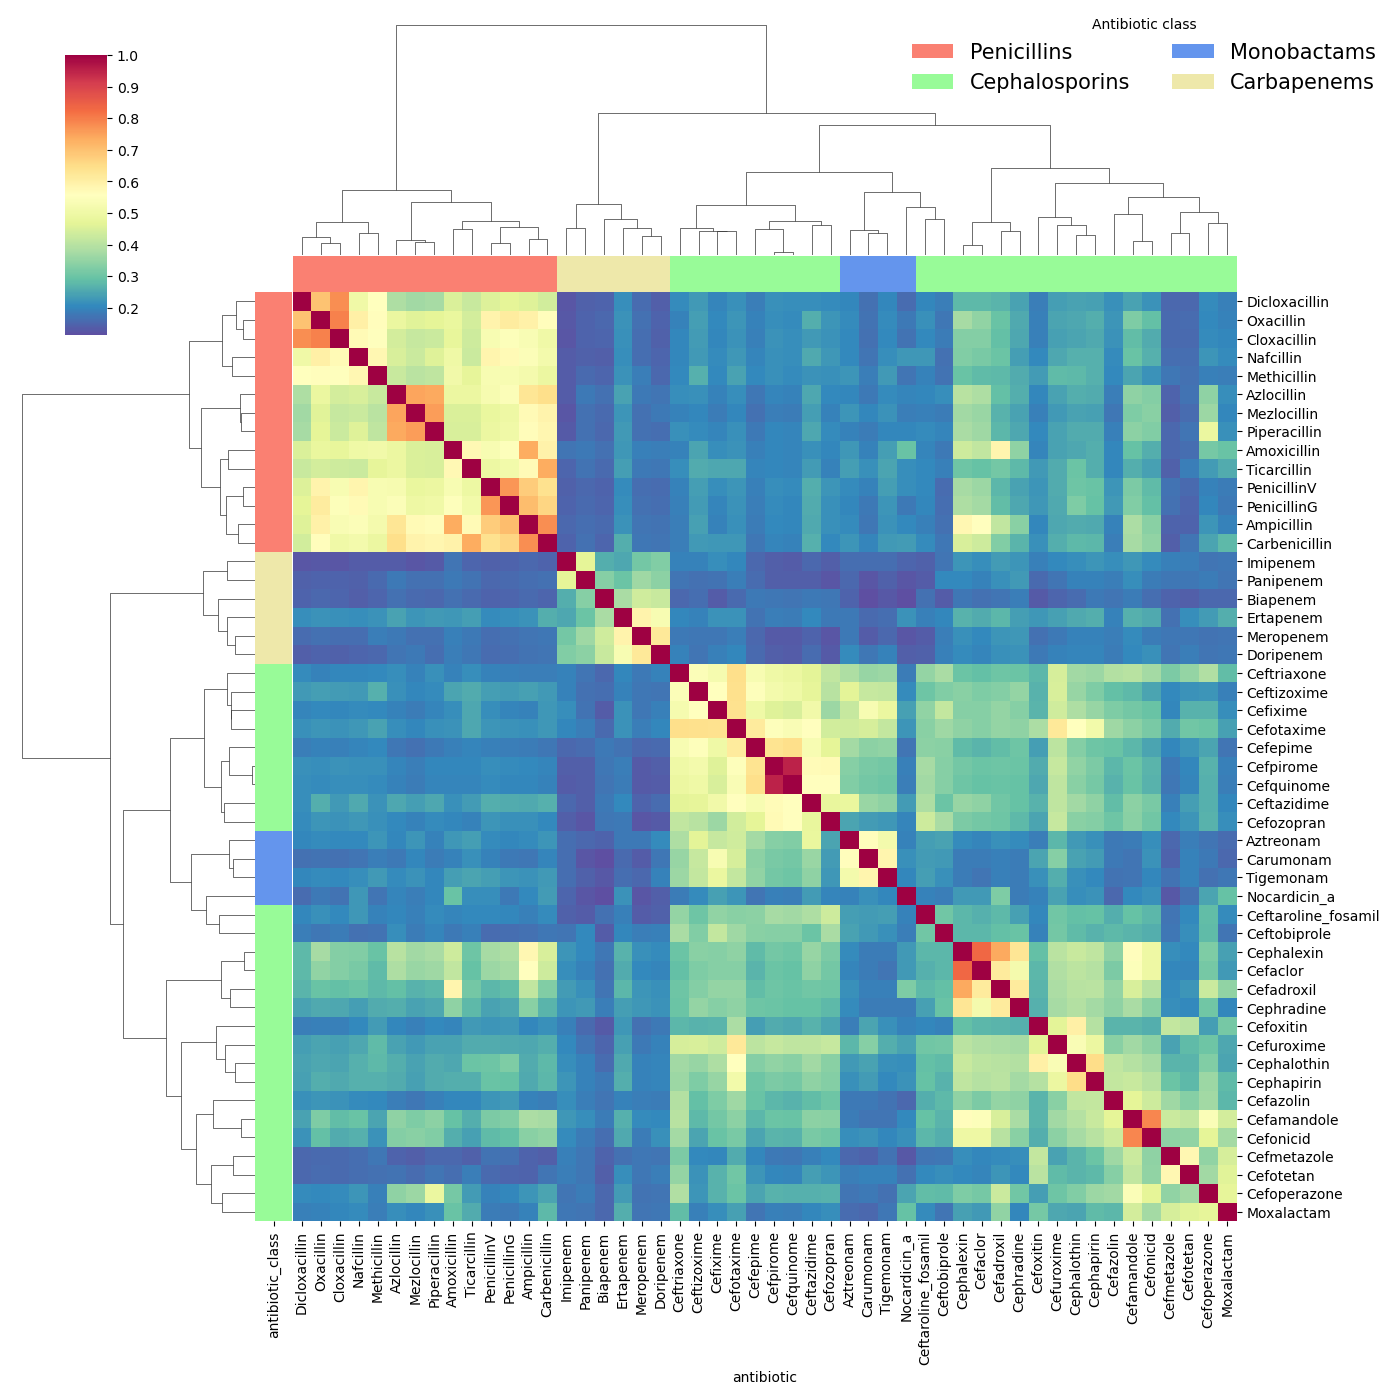

/tmp/ipykernel_2217/3282489028.py:46: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  dend = shc.dendrogram(shc.linkage(dist_matrix, method='ward'),


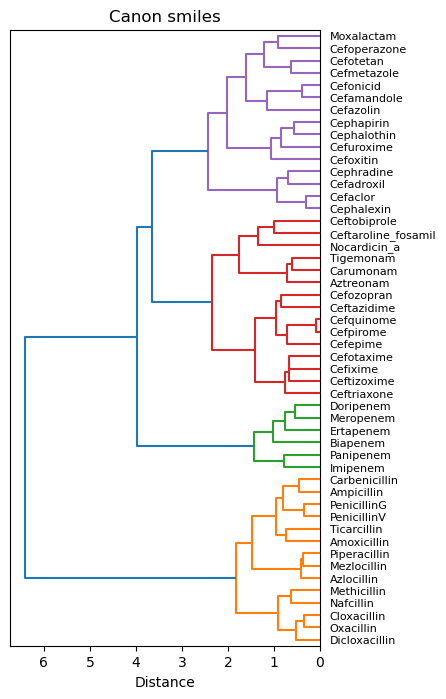

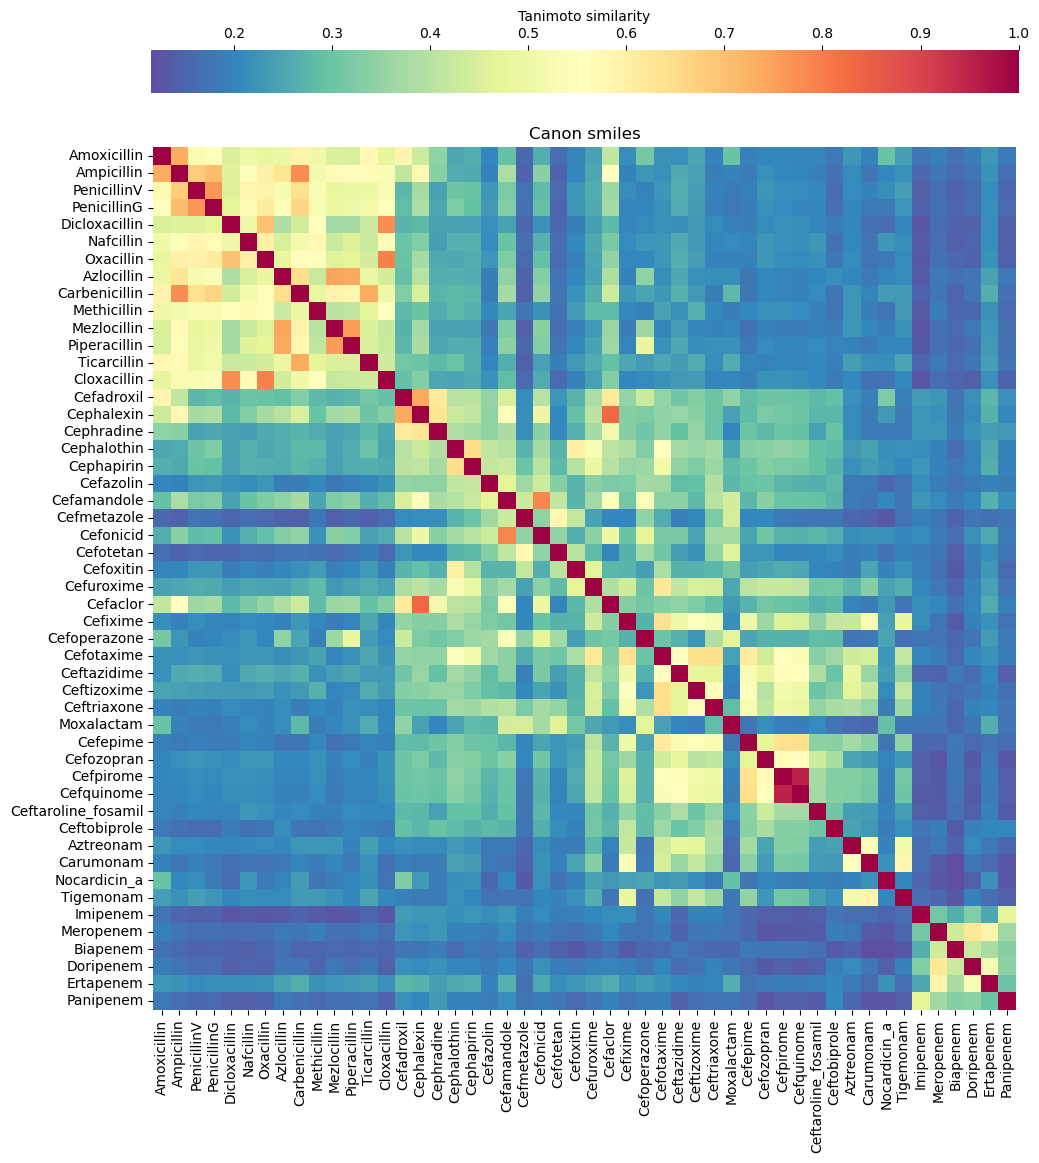

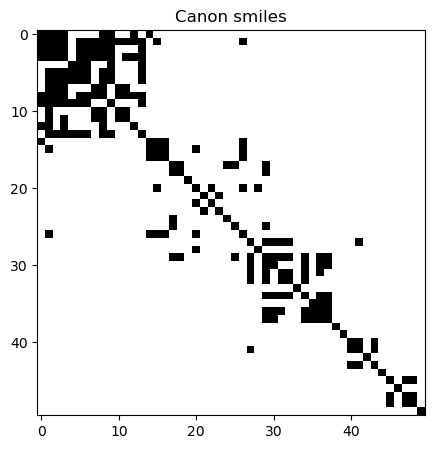

In [82]:
tanimoto_plots(df_smiles.canonical_smile, "tanimoto_sim_canon", "Canon smiles")

Dataset saved as: ../results/tanimoto/tanimoto_sim_iso.csv


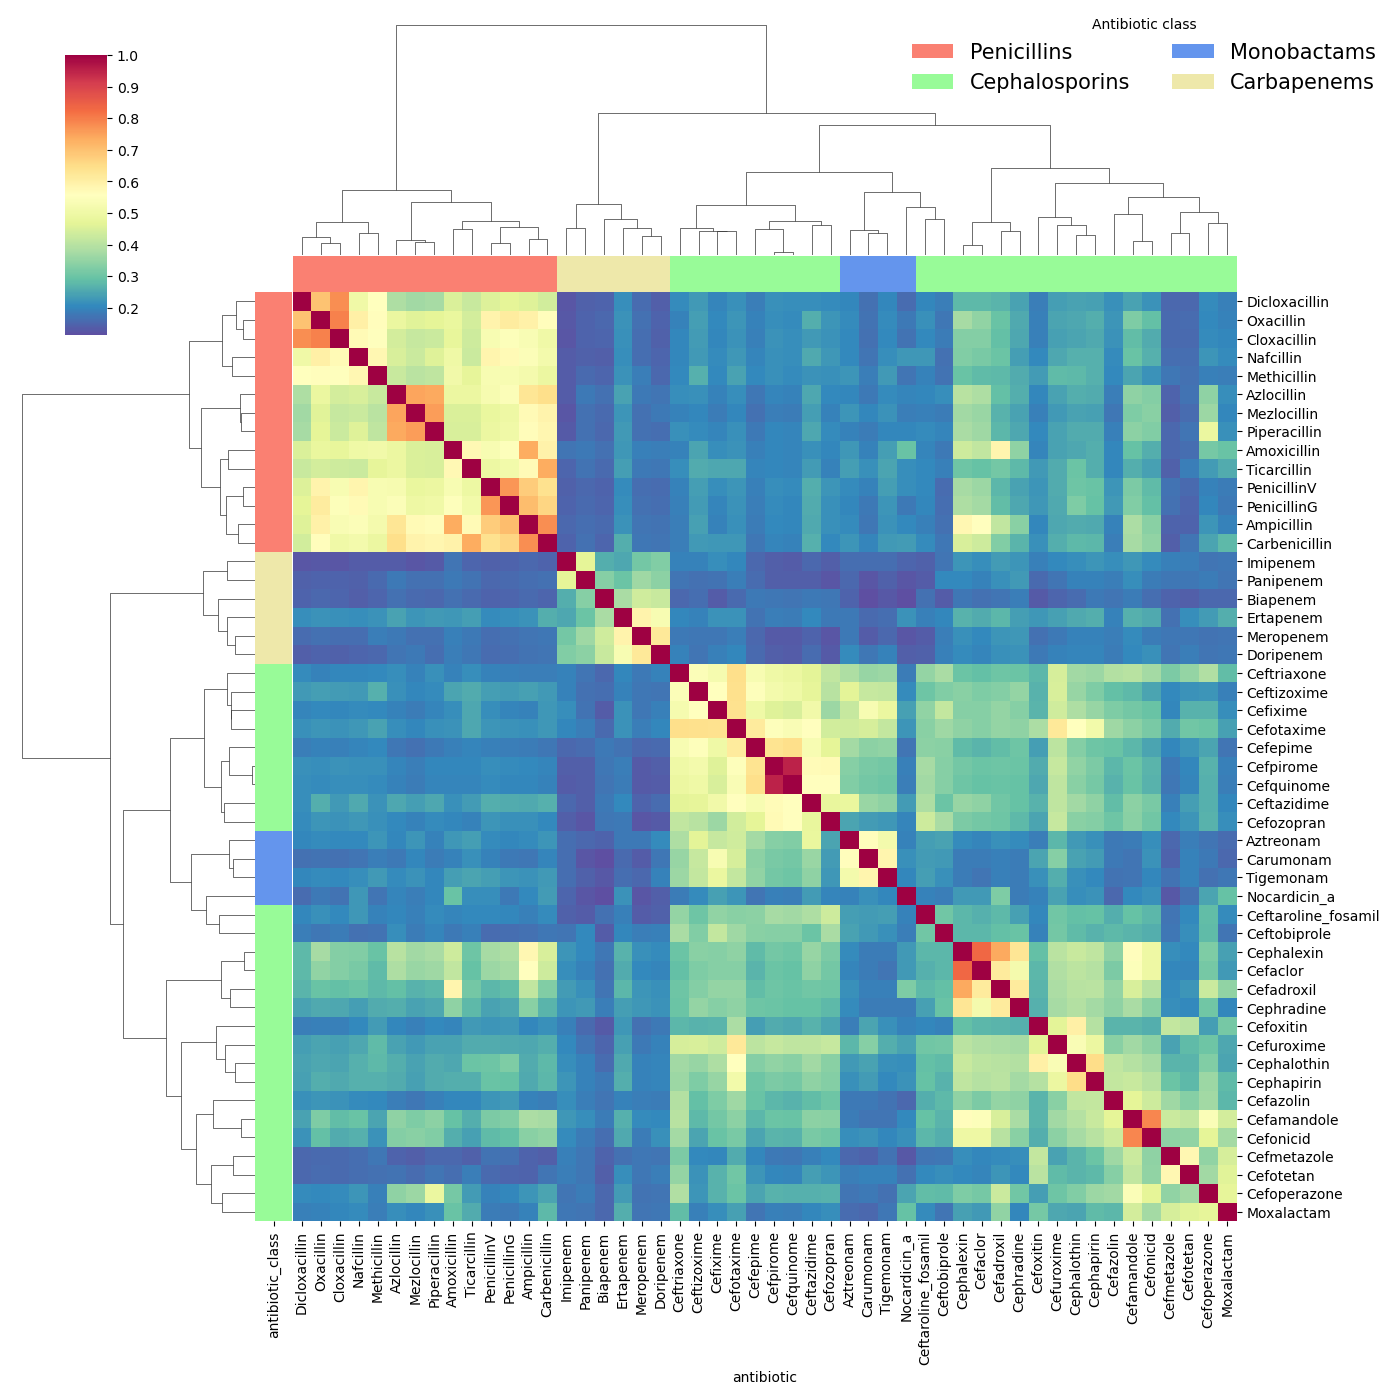

/tmp/ipykernel_2217/3282489028.py:46: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  dend = shc.dendrogram(shc.linkage(dist_matrix, method='ward'),


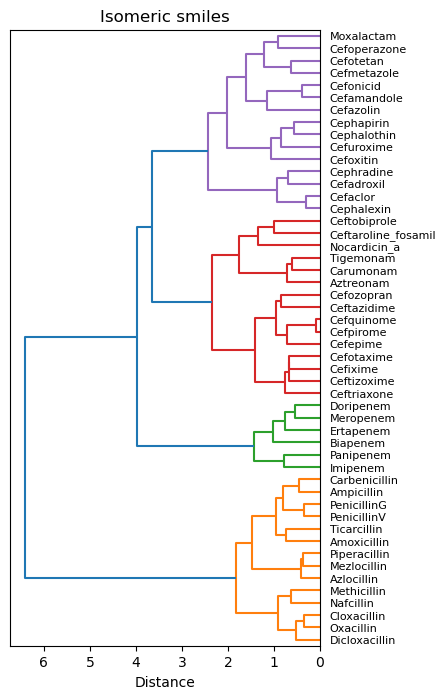

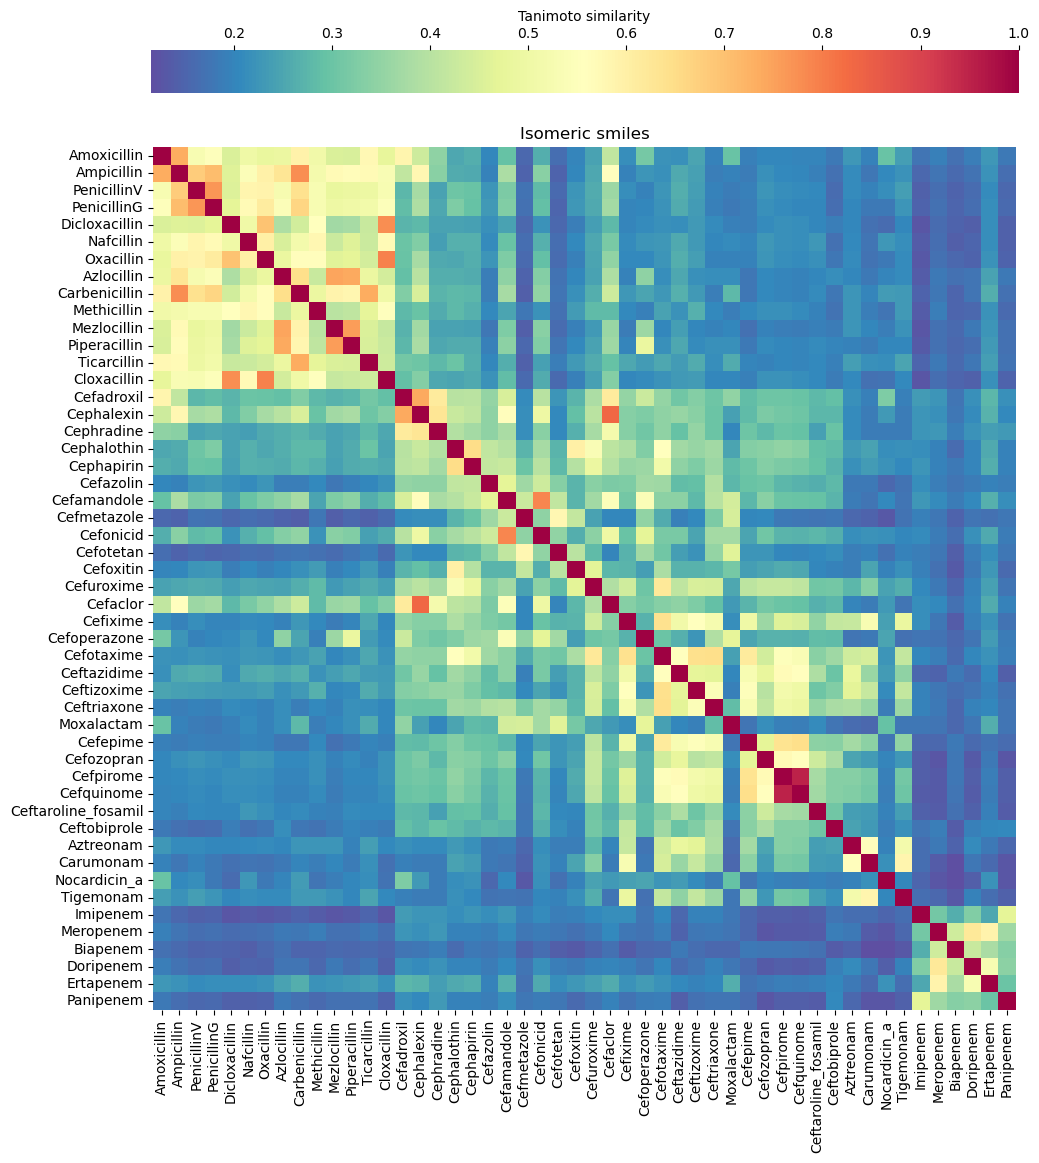

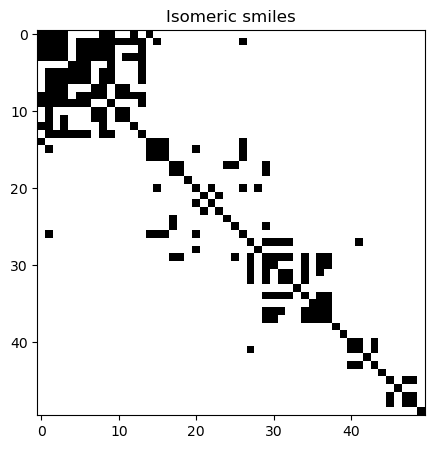

In [83]:
tanimoto_plots(df_smiles.isomeric_smile, "tanimoto_sim_iso", "Isomeric smiles")

In [84]:
# extendend plot 

canonical smiles


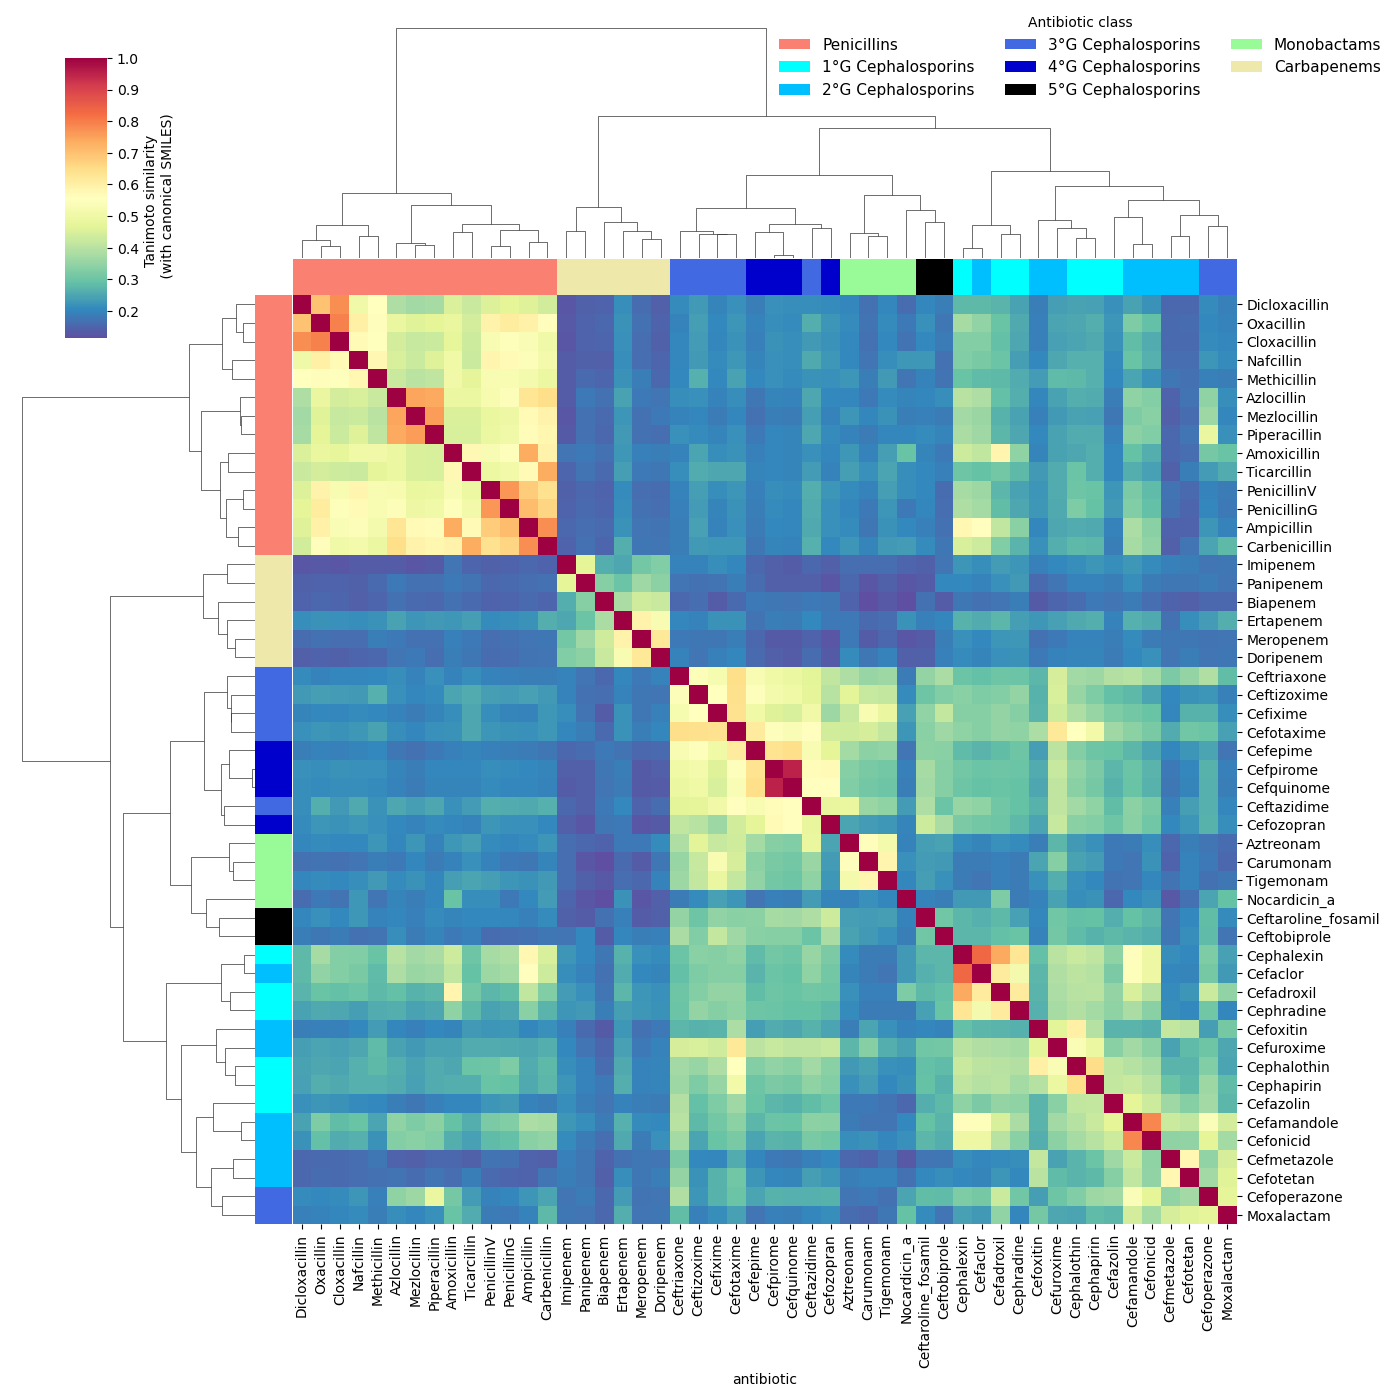

In [85]:
# compute the tanimoto matrix
print("canonical smiles")
sim_matrix = tanimoto_matrix(df_smiles.canonical_smile)

# create a df 
df_sim = pd.DataFrame(sim_matrix, columns = df_smiles.antibiotic)
df_sim["anti_class_expand"] = df_smiles.anti_class_expand
df_sim["antibiotic"] = df_smiles.antibiotic
# drop anti name col
dropcol = df_sim.pop("antibiotic")
# insert column 
df_sim.insert(0, "antibiotic", dropcol)

# cluster plot
# create a color palette and legend structure
colors = df_sim.anti_class_expand.map({
    "Penicillins": "salmon",
    
    "1°G Cephalosporins": "cyan",
    "2°G Cephalosporins": "deepskyblue",
    "3°G Cephalosporins": "royalblue",
    "4°G Cephalosporins": "mediumblue",
    "5°G Cephalosporins": "black",
    
    "Monobactams": "palegreen",
    "Carbapenems": "palegoldenrod"})
lut = dict(zip(df_sim.anti_class_expand.to_list(), colors))
handles = [Patch(facecolor = lut[name]) for name in lut]

# plot 
df_num = df_sim.select_dtypes(["number"])
sns.clustermap(df_num, method = "ward", metric="euclidean",
    cmap = "Spectral_r", figsize=(14, 14), xticklabels = True, yticklabels = df_sim.antibiotic,
    robust = False, row_colors = colors.to_list(), col_colors = colors.to_list(),
               cbar_pos = (0.05, 0.76, 0.03,0.2), cbar_kws={'label': 'Tanimoto similarity \n (with canonical SMILES)'} )
plt.legend(handles, lut, title = "Antibiotic class", loc = "best", frameon = False, ncol = 3,
    bbox_to_anchor=(1, 1), bbox_transform=plt.gcf().transFigure, prop={'size': 11})
plt.show()

isomeric smiles


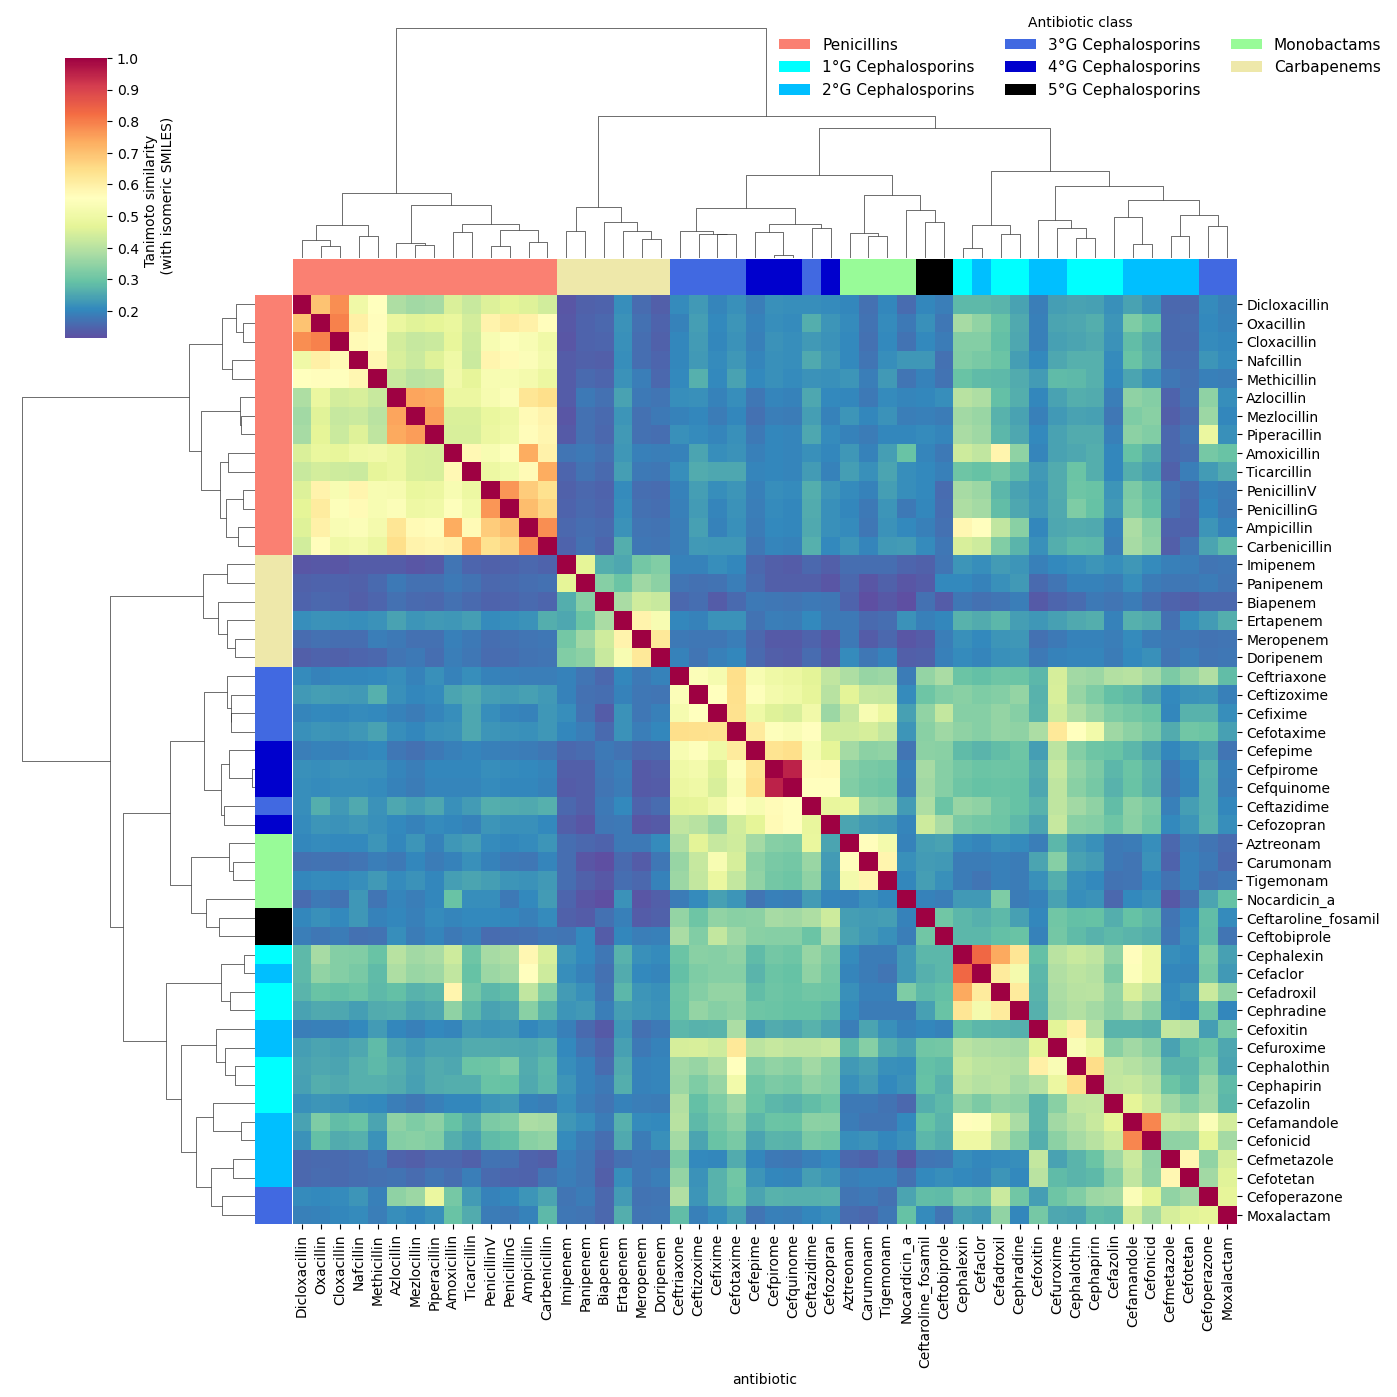

In [86]:
# compute the tanimoto matrix
print("isomeric smiles")
sim_matrix = tanimoto_matrix(df_smiles.isomeric_smile)

# create a df 
df_sim = pd.DataFrame(sim_matrix, columns = df_smiles.antibiotic)
df_sim["anti_class_expand"] = df_smiles.anti_class_expand
df_sim["antibiotic"] = df_smiles.antibiotic
# drop anti name col
dropcol = df_sim.pop("antibiotic")
# insert column 
df_sim.insert(0, "antibiotic", dropcol)

# cluster plot
# create a color palette and legend structure
colors = df_sim.anti_class_expand.map({
    "Penicillins": "salmon",
    
    "1°G Cephalosporins": "cyan",
    "2°G Cephalosporins": "deepskyblue",
    "3°G Cephalosporins": "royalblue",
    "4°G Cephalosporins": "mediumblue",
    "5°G Cephalosporins": "black",
    
    "Monobactams": "palegreen",
    "Carbapenems": "palegoldenrod"})
lut = dict(zip(df_sim.anti_class_expand.to_list(), colors))
handles = [Patch(facecolor = lut[name]) for name in lut]

# plot 
df_num = df_sim.select_dtypes(["number"])
sns.clustermap(df_num, method = "ward", metric="euclidean",
    cmap = "Spectral_r", figsize=(14, 14), xticklabels = True, yticklabels = df_sim.antibiotic,
    robust = False, row_colors = colors.to_list(), col_colors = colors.to_list(),
    cbar_pos = (0.05, 0.76, 0.03,0.2), cbar_kws={'label': 'Tanimoto similarity \n (with isomeric SMILES)'})
plt.legend(handles, lut, title = "Antibiotic class", loc = "best", frameon = False, ncol = 3,
    bbox_to_anchor=(1, 1), bbox_transform=plt.gcf().transFigure, prop={'size': 11})
plt.show()

fin